# Asses final results of all experiments
Every aspect in separate section.

## Setup

#### Imports

In [1]:
# General imports
import multiprocessing
import numpy as np
import pandas as pd
import time
import sys
import dill
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import collections
import os

# Sklearn imports
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Lasso, ElasticNet
from stability_selection import StabilitySelection
from scipy.stats import pearsonr

/home/krzysztof/anaconda3/envs/modeling_drug_efficacy/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Add directory to sys.path in order to import custom modules from there.
sys.path.insert(0, "/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Projects/Created Modules/")
from gdsc_projects_module import DrugWithDrugBank, DrugGenomeWide, DrugWithGenesInSamePathways, Experiment, Modeling, ModelingResults

#### Load general data

In [3]:
# Initialize proper file pathways
drug_annotations = "/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Data/Original Data/Genomics of Drug Sensitivity in Cancer/Original GDSC Data/Drug annotations/Screened_Compounds-March_27th_2018.xlsx"
cell_line_list = "/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Data/Original Data/Genomics of Drug Sensitivity in Cancer/Original GDSC Data/Cell line list (directly from website)/Cell_listThu Aug 16 22_06_49 2018.csv"
gene_expr = "/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Data/Original Data/Genomics of Drug Sensitivity in Cancer/Original GDSC Data/Gene expression/sanger1018_brainarray_ensemblgene_rma-March_2nd_2017.txt"
cnv1 = "/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Data/Original Data/Genomics of Drug Sensitivity in Cancer/Original GDSC Data/Copy number variations/cnv_binary_1.csv"
cnv2 = "/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Data/Original Data/Genomics of Drug Sensitivity in Cancer/Original GDSC Data/Copy number variations/PANCANCER_Genetic_feature_cna_Mon Aug  6 16_18_51 2018 (kopia).csv"
coding_variants = "/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Data/Original Data/Genomics of Drug Sensitivity in Cancer/Original GDSC Data/Mutation calls/PANCANCER_Genetic_feature_variant_Mon Aug  6 15_45_44 2018.csv"
drug_response = "/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Data/Original Data/Genomics of Drug Sensitivity in Cancer/Original GDSC Data/Sensitivity profiles/v17.3_fitted_dose_response-March_27th_2018.xlsx"

# Load dictionary with targets derived from DrugBank
drugbank_targets = "/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Data/Original Data/DrugBank/Created data/drugbank_map_drug_to_targets.p"

# Load dictionary mapping from target genes to genes that occur in same pathways
reactome_pathway_related_genes = "/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Data/Original Data/Reactome/Created Reactome Data/map_target_genes_to_genes_involved_in_same_pathways.pkl"

# Filepath to gene expression signatures provided by Merck
signatures = "/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Data/Created data/Merck Gene Expression Signatures/Data/SignatureScores_GDSC-cellLines_2018-09-27.tsv"

# Call loading function from DrugWithGenesInSamePathways class
(drug_annotations_df, cell_lines_list_df, gene_expression_df, cnv_binary_df, 
 coding_variants_df, drug_response_df, map_drugs_to_drugbank_targets, 
 map_target_genes_to_same_pathways_genes) = DrugWithGenesInSamePathways.load_data(
    drug_annotations, cell_line_list, gene_expr, 
    cnv1, cnv2, coding_variants, drug_response, drugbank_targets, reactome_pathway_related_genes)

# Load gene expression signatures
signatures_df = pd.read_table(signatures)

# Load helper dict for extraction of CNV data
filepath = "/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Data/Original Data/Genomics of Drug Sensitivity in Cancer/Original GDSC Data/Copy number variations/Created data/"
with open(filepath + "map_cl_id_and_genetic_feature_to_mutation_status.pkl", "rb") as f:
    map_from_cl_id_and_genetic_feature_to_mutation_status = dill.load(f)


# Load gene mappings
filepath1 = "/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Projects/GDSC - Prediction only with data related to nominal drug targets (minimal approach)/Created data/mapping_from_ensembl_id_to_hgnc_symbol.p"
filepath2 = "/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Projects/GDSC - Prediction only with data related to nominal drug targets (minimal approach)/Created data/mapping_from_hgnc_symbol_to_ensembl_id.p"
with open("../Results Assesment/Results and other files/mapper_from_ensembl_to_hgnc.pkl", "rb") as f:
    map_ensembl_to_hgnc = dill.load(f)
# Initialize class variables
DrugWithDrugBank.load_mappings(filepath2, filepath1)
DrugGenomeWide.load_mappings(filepath2, filepath1)
DrugWithGenesInSamePathways.load_mappings(filepath2, filepath1) 

# Print shapes of created DataFrames
print("Loading summary:")
print("Drug annotations:", drug_annotations_df.shape)
print("Cell line list", cell_lines_list_df.shape)
print("Gene expression", gene_expression_df.shape)
print("CNV binary:", cnv_binary_df.shape)
print("Coding variants:", coding_variants_df.shape)
print("Drug response:", drug_response_df.shape)
print("DrugBank mapping (number of matched drugs):", len(map_drugs_to_drugbank_targets))
print("Target gene mapping (number of target genes with match):", len(map_target_genes_to_same_pathways_genes))
print("Gene expression signatures:", signatures_df.shape)
print("Number of entries in mapping from cell line and cnv genetic feature to mutation status:",
     len(map_from_cl_id_and_genetic_feature_to_mutation_status))

Loading summary:
Drug annotations: (267, 5)
Cell line list (1065, 6)
Gene expression (17737, 1019)
CNV binary: (419050, 9)
Coding variants: (295740, 9)
Drug response: (224202, 13)
DrugBank mapping (number of matched drugs): 88
Target gene mapping (number of target genes with match): 200
Gene expression signatures: (128, 1018)
Number of entries in mapping from cell line and cnv genetic feature to mutation status: 419050


In [4]:
# Create dictionary with Drug objects
drugs = DrugGenomeWide.create_drugs(drug_annotations_df)
print(len(drugs))

267


## Load ModelingResults objects (raw results)

In [5]:
# Set directory with results
filepath = "Final experimental raw results/"

# Load only targets ENet
with open(filepath + "only_targets-enet_over_few_data_splits.pkl", "rb") as f:
    only_targets_enet = dill.load(f)
print(type(only_targets_enet), len(only_targets_enet.performance_dict))

# Load only targets RForest
with open(filepath + "only_targets-rforest_over_few_data_splits.pkl", "rb") as f:
    only_targets_rforest = dill.load(f)
print(type(only_targets_rforest), len(only_targets_rforest.performance_dict))

# Load only targets with signatures ENet
with open(filepath + "only_targets_with_signatures-enet_over_few_data_splits.pkl", "rb") as f:
    only_targets_with_signatures_enet = dill.load(f)
print(type(only_targets_with_signatures_enet), len(only_targets_with_signatures_enet.performance_dict))

# Load only targets with signatures RForest
with open(filepath + "only_targets_with_signatures-rforest_over_few_data_splits.pkl", "rb") as f:
    only_targets_with_signatures_rforest = dill.load(f)
print(type(only_targets_with_signatures_rforest), len(only_targets_with_signatures_rforest.performance_dict))

# Load pathway genes ENet
with open(filepath + "pathway_genes-enet_over_few_data_splits.pkl", "rb") as f:
    pathway_genes_enet = dill.load(f)
print(type(pathway_genes_enet), len(pathway_genes_enet.performance_dict))

# Load pathway genes RForest
with open(filepath + "pathway_genes-rforest_over_few_data_splits.pkl", "rb") as f:
    pathway_genes_rforest = dill.load(f)
print(type(pathway_genes_rforest), len(pathway_genes_rforest.performance_dict))

# Load pathway genes with signatures ENet
with open(filepath + "pathway_genes_with_signatures-enet_over_few_data_splits_limited.pkl", "rb") as f:
    pathway_genes_with_signatures_enet = dill.load(f)
print(type(pathway_genes_with_signatures_enet), len(pathway_genes_with_signatures_enet.performance_dict))

# Load pathway genes with signatures RForest
with open(filepath + "pathway_genes_with_signatures-rforest_over_few_data_splits_limited.pkl", "rb") as f:
    pathway_genes_with_signatures_rforest = dill.load(f)
print(type(pathway_genes_with_signatures_rforest), len(pathway_genes_with_signatures_rforest.performance_dict))

# # Load genome-wide with feature selection ENet
# with open(filepath + "enet_with_standardscaler_and_feature_selection.pkl", "rb") as f:
#     genome_wide_with_selection_enet = dill.load(f)
# print(type(genome_wide_with_selection_enet), len(genome_wide_with_selection_enet.performance_dict))

# # Load genome-wide with feature selection RForest
# with open(filepath + "randomforest_with_standardscaler_and_feature_selection_without_importances.pkl", "rb") as f:
#     genome_wide_with_selection_rforest = dill.load(f)
# print(type(genome_wide_with_selection_rforest), len(genome_wide_with_selection_rforest.performance_dict))

# # Load genome-wide without feature selection ENet
# with open(filepath + "genome_wide-enet_over_few_data_splits_without_feature_selection.pkl", "rb") as f:
#     genome_wide_without_selection_enet = dill.load(f)
# print(type(genome_wide_without_selection_enet), len(genome_wide_without_selection_enet.performance_dict))

# # Load genome-wide without feature selection RForest
# with open(filepath + "genome_wide-rforest_over_few_data_splits_without_feature_selection.pkl", "rb") as f:
#     genome_wide_without_selection_rforest = dill.load(f)
# print(type(genome_wide_without_selection_rforest), len(genome_wide_without_selection_rforest.performance_dict))

<class 'gdsc_projects_module.ModelingResults'> 184
<class 'gdsc_projects_module.ModelingResults'> 184
<class 'gdsc_projects_module.ModelingResults'> 184
<class 'gdsc_projects_module.ModelingResults'> 184
<class 'gdsc_projects_module.ModelingResults'> 186
<class 'gdsc_projects_module.ModelingResults'> 186
<class 'gdsc_projects_module.ModelingResults'> 186
<class 'gdsc_projects_module.ModelingResults'> 186


## Load DataFrames with results

In [6]:
! ls 'Results and other files'

aggregated_performance_all_models.csv
bad_drugs.pkl
best_results_from_two_groups.csv
best_results_per_drug_across_all_settings.csv
data_shapes_per_drug_in_models.csv
df_agg_all_drugs_restricted_vs_genome_wide.csv
df_best_results_per_drug_from_restricted_models.csv
drug_ids_to_keep_in_results.pkl
drug_response_df_with_pathways.csv
drugs_of_interest.csv
feature_importances_all_restricted_modelings.pkl
feature_importances_from_best_restricted_model_per_drug.pkl
gw_all_data_feat_list.pkl
gw_expression_feat_list.pkl
hue_order_all_models.pkl
intersection_of_drugs_between_models.pkl
mapper_from_ensembl_to_hgnc.pkl
modeling_gw_exps_alone_vs_gw_all_features.pkl
Notes.txt
palette_all_models.pkl
raw_performance_all_models.csv
set_of_all_analyzed_cell_lines.pkl
tp_names_abbrevations.pkl


In [7]:
# Load list containing IDs of bad drugs
with open("./Results and other files/bad_drugs.pkl", "rb") as f:
    bad_drugs = dill.load(f)
print(type(bad_drugs), len(bad_drugs))

<class 'list'> 19


In [8]:
# Load results for all settings, not aggregated over data splits
df_raw_all_models = pd.read_csv('./Results and other files/raw_performance_all_models.csv')
df_raw_all_models_filtered = df_raw_all_models[~df_raw_all_models["Drug ID"].isin(bad_drugs)]
print(df_raw_all_models.shape, df_raw_all_models_filtered.shape)
df_raw_all_models_filtered.head(3)

(12115, 11) (11215, 11)


,Drug ID,Drug Name,Split seed,Model test RMSE,Model test correlation,Correlation pval,Dummy test RMSE,Relative test RMSE,Target Pathway,Model,Best k
0,1,Erlotinib,11,0.088977,0.386896,4.561981e-05,0.096257,1.081822,EGFR signaling,OT EN,NaN
1,1,Erlotinib,37,0.061968,0.543188,2.138906e-09,0.070966,1.145203,EGFR signaling,OT EN,NaN
2,1,Erlotinib,52,0.096144,0.422583,7.103247e-06,0.103601,1.077567,EGFR signaling,OT EN,NaN


In [9]:
# Load results for all settings, aggregated over data splits
df_agg_all_models = pd.read_csv('./Results and other files/aggregated_performance_all_models.csv')
df_agg_all_models_filtered = df_agg_all_models[~df_agg_all_models["Drug ID"].isin(bad_drugs)]
print(df_agg_all_models.shape, df_agg_all_models_filtered.shape)
df_agg_all_models_filtered.head(3)

(2423, 9) (2243, 9)


,Drug ID,Drug Name,Model test RMSE,Model test correlation,Correlation pval,Dummy test RMSE,Relative test RMSE,Target Pathway,Model
0,1,Erlotinib,0.086347,0.388664,0.001450,0.0924,1.075011,EGFR signaling,OT EN
1,1,Erlotinib,0.086797,0.356010,0.000767,0.0924,1.062901,EGFR signaling,PG EN
2,1,Erlotinib,0.086307,0.375711,0.000364,0.0924,1.071611,EGFR signaling,PG + S EN


In [10]:
# Load DataFrame with best results per drug across all settings
df_best_results = pd.read_csv("./Results and other files/best_results_per_drug_across_all_settings.csv")
df_best_results_filtered = df_best_results[~df_best_results["Drug ID"].isin(bad_drugs)]
print(df_best_results.shape, df_best_results_filtered.shape)
df_best_results_filtered.head(3)

(251, 9) (232, 9)


,Drug ID,Drug Name,Model test correlation,Correlation pval,Relative test RMSE,Model test RMSE,Dummy test RMSE,Corresponding experiment,Target Pathway
0,1373,Dabrafenib,0.752645,1.075014e-40,1.514006,0.127750,0.193280,OT + S RF,ERK MAPK signaling
1,277,Linifanib,0.749668,4.346970e-19,1.483354,0.055801,0.080856,OT RF,RTK signaling
2,1372,Trametinib,0.708743,3.211507e-40,1.404737,0.202283,0.284112,GW EN,ERK MAPK signaling


In [11]:
# Load intersection of drugs between all tested models
with open("./Results and other files/intersection_of_drugs_between_models.pkl", "rb") as f:
    drug_intersection = dill.load(f)
print(type(drug_intersection), len(drug_intersection))

<class 'list'> 175


In [12]:
# Load DataFrame with best results coming from two groups of models, unfiltered, for every drug in itersection
df_best_results_from_two_groups = pd.read_csv("./Results and other files/best_results_from_two_groups.csv")
df_best_results_from_two_groups_filtered = df_best_results_from_two_groups[
    ~df_best_results_from_two_groups["Drug ID"].isin(bad_drugs)]
print(df_best_results_from_two_groups.shape, df_best_results_from_two_groups_filtered.shape)
df_best_results_from_two_groups_filtered.head(3)

(350, 9) (324, 9)


,Drug ID,Drug Name,Model test RMSE,Model test correlation,Correlation pval,Dummy test RMSE,Relative test RMSE,Target Pathway,Model
0,1,Erlotinib,0.085320,0.410257,0.000308,0.092400,1.086402,EGFR signaling,Restricted
1,1,Erlotinib,0.071460,0.374202,0.004133,0.073378,1.017662,EGFR signaling,Genome-wide
2,3,Rapamycin,0.223836,0.253258,0.042695,0.229805,1.027091,PI3K/MTOR signaling,Restricted


# Sections

## Take a look at PG models

In [113]:
# How many best models are PG models
pg_mods = ["PG EN", "PG RF", "PG + S EN", "PG + S RF"]

data = df_best_results[
    df_best_results["Corresponding experiment"].isin(pg_mods)
]
print(data.shape)
data.head()

(33, 9)


,Drug ID,Drug Name,Model test correlation,Correlation pval,Relative test RMSE,Model test RMSE,Dummy test RMSE,Corresponding experiment,Target Pathway
8,275,I-BET-762,0.653524,1.073992e-26,1.318135,0.115021,0.151155,PG + S EN,Chromatin other
15,1060,PD0325901,0.634638,2.455801e-22,1.286616,0.135650,0.174358,PG + S EN,ERK MAPK signaling
26,303,PIK-93,0.614939,4.940367e-24,1.261685,0.146234,0.184440,PG + S RF,PI3K/MTOR signaling
31,254,Quizartinib,0.604061,3.277115e-05,1.420970,0.061652,0.081050,PG RF,RTK signaling
51,1061,SB590885,0.555979,2.601296e-16,1.136526,0.059179,0.068327,PG EN,ERK MAPK signaling


## Comparison of GW gene expression vs. GW with all available data (expression, mutation, CNV, tissue)

In [54]:
# Load object with results
with open("Results and other files/modeling_gw_exps_alone_vs_gw_all_features.pkl", "rb") as f:
    gw_exp_vs_all_res = dill.load(f)
print(type(gw_exp_vs_all_res), len(gw_exp_vs_all_res.all_data_results))
data = gw_exp_vs_all_res.create_results_df()
print(data.shape)
data.tail(4)

<class 'gdsc_projects_module.ModelingWithEqualRights'> 251
(502, 8)


,Drug ID,Drug Name,Test RMSE,Test correlation,Correlation pval,Train RMSE,Train correlation,Model
498,1529,Pevonedistat,0.099931,4.885568e-01,2.468733e-13,0.079947,8.766836e-01,Expression alone
499,1529,Pevonedistat,0.100058,4.864952e-01,3.213948e-13,0.078462,8.848600e-01,All data
500,1530,PFI-3,0.024367,3.069776e-15,1.000000e+00,0.016696,-1.543664e-16,Expression alone
501,1530,PFI-3,0.024367,3.069776e-15,1.000000e+00,0.016696,-1.543664e-16,All data


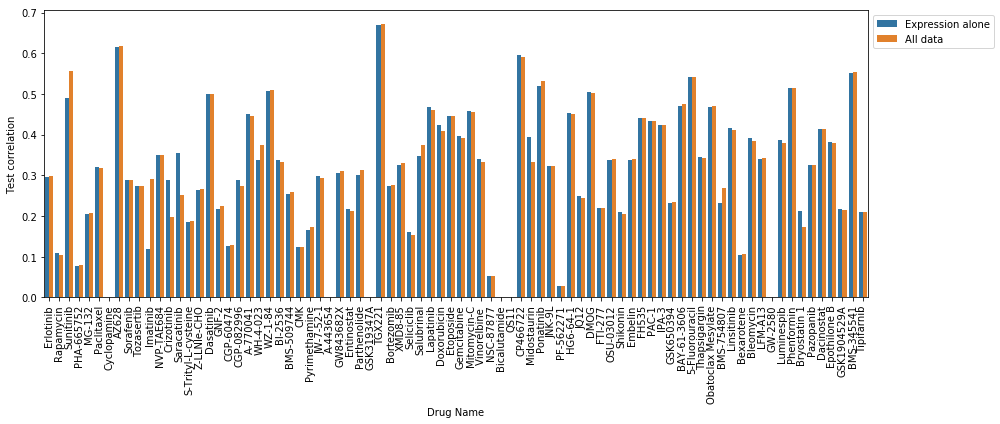

In [57]:
# Plot correlation per drug - 1st third
drugs_to_plot = data["Drug ID"].unique()[:82]
hue_order = ["Expression alone", "All data"]

plt.figure(figsize=(14, 6))
ax = sns.barplot(x="Drug Name", y="Test correlation", hue="Model",
                data=data[data["Drug ID"].isin(drugs_to_plot)],
                hue_order=hue_order)
ax.tick_params(axis="x", rotation=90, labelsize=10)

plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.tight_layout()
plt.savefig("/home/krzysztof/Pulpit/doktorat_stuff/gw_vs_all1.pdf")
plt.show()

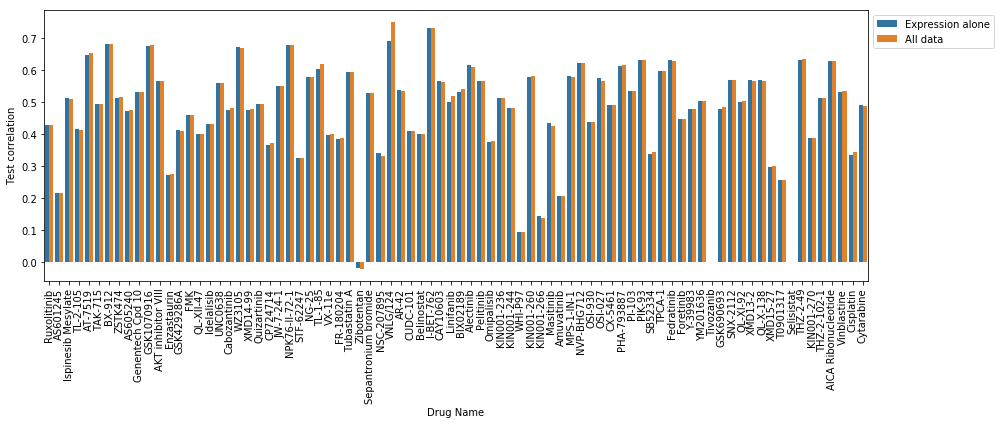

In [58]:
# Plot correlation per drug - 2nd third
drugs_to_plot = data["Drug ID"].unique()[82:164]
hue_order = ["Expression alone", "All data"]

plt.figure(figsize=(14, 6))
ax = sns.barplot(x="Drug Name", y="Test correlation", hue="Model",
                data=data[data["Drug ID"].isin(drugs_to_plot)],
                hue_order=hue_order)
ax.tick_params(axis="x", rotation=90, labelsize=10)

plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.tight_layout()
plt.savefig("/home/krzysztof/Pulpit/doktorat_stuff/gw_vs_all2.pdf")

plt.show()

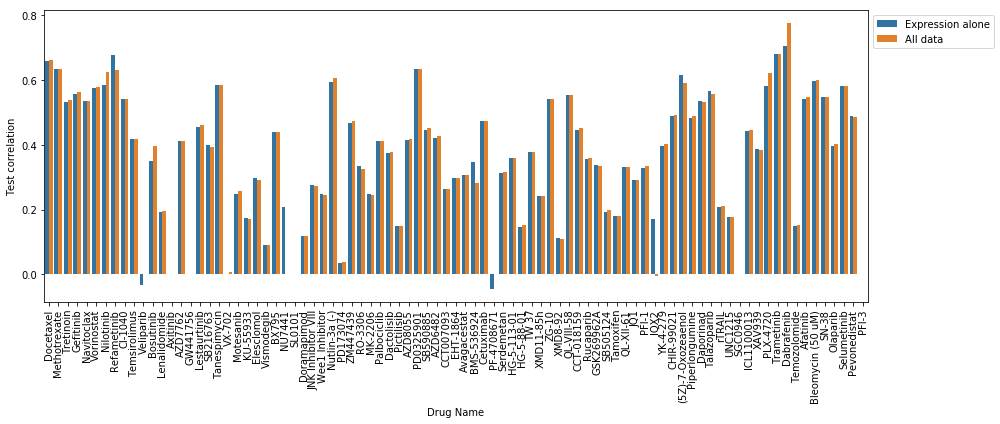

In [59]:
# Plot correlation per drug - 3rd third
drugs_to_plot = data["Drug ID"].unique()[164:]
hue_order = ["Expression alone", "All data"]

plt.figure(figsize=(14, 6))
ax = sns.barplot(x="Drug Name", y="Test correlation", hue="Model",
                data=data[data["Drug ID"].isin(drugs_to_plot)],
                hue_order=hue_order)
ax.tick_params(axis="x", rotation=90, labelsize=10)

plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.tight_layout()

plt.savefig("/home/krzysztof/Pulpit/doktorat_stuff/gw_vs_all3.pdf")

plt.show()

## Feature importances GW all available data types|

In [62]:
# Load object with results
with open("Results and other files/modeling_gw_exps_alone_vs_gw_all_features.pkl", "rb") as f:
    gw_exp_vs_all_res = dill.load(f)
print(type(gw_exp_vs_all_res), len(gw_exp_vs_all_res.all_data_results))
data = gw_exp_vs_all_res.create_results_df()
print(data.shape)
data.sample(4)

<class 'gdsc_projects_module.ModelingWithEqualRights'> 251
(502, 8)


,Drug ID,Drug Name,Test RMSE,Test correlation,Correlation pval,Train RMSE,Train correlation,Model
89,147,NSC-87877,0.027744,0.052370,4.125290e-01,0.027956,0.816527,Expression alone
94,152,CP466722,0.099946,0.589694,1.191064e-25,0.037459,0.968201,All data
132,182,Obatoclax Mesylate,0.207192,0.470395,7.740208e-15,0.146116,0.836114,All data
283,303,PIK-93,0.133692,0.632020,2.734806e-30,0.101316,0.860521,Expression alone


In [70]:
drug_name = "Erlotinib"
drug_id = 1
drug_tuple = (drug_name, drug_id)

gw_exp_vs_all_res.grids[drug_tuple][1].best_estimator_.named_steps["estimator"].coef_

array([-2.20565347e-04,  5.44978468e-05,  1.92777791e-06, ...,
        1.47199139e-05,  1.94547254e-05,  5.91598182e-05])

In [73]:
split_seed = 98

drugs_gw = DrugGenomeWide.create_drugs(drug_annotations_df)
drug = drugs_gw[1]

print("DRUG", drug.name, drug_id)
drug_tuple = (drug.name, drug_id)


# Create full data for only exressions
data_exp_alone = drug.return_full_data(drug_response_df, gene_expression_df, data_combination=["expression"])
print("Shape of created expression alone data:", data_exp_alone.shape)

# Create full data for restricted model
data_types = ["CNV", "mutation", "expression", "tissue", "merck signatures"]
data_all = drug.create_full_data(drug_response_df, data_combination=data_types, 
                                 gene_expression_df=gene_expression_df, 
                                 cnv_binary_df=cnv_binary_df,
                                 map_cl_id_and_feature_to_status=map_from_cl_id_and_genetic_feature_to_mutation_status,
                                 cell_line_list=cell_lines_list_df,
                                 mutation_df=coding_variants_df,
                                 merck_signatures_df=signatures_df)

print("Shape of created expression plus mutation data:", data_all.shape)

X_train_exp, X_test_exp, X_train_exp_mut, X_test_exp_mut, y_train_both, y_test_both = ModelingResults.prepare_data_for_scatter_plots(
data_exp_alone, data_all, split_seed)

print("X_train_exp and X_train_exp_mut shape:", X_train_exp.shape, X_train_exp_mut.shape)
print("X_test_exp and X_test_exp_mut shape:", X_test_exp.shape, X_test_exp_mut.shape)
print("y_both_train and y_both_test shape:", y_train_both.shape, y_test_both.shape)
print(y_test_both.sum())

DRUG Erlotinib 1


/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Projects/Created Modules/gdsc_projects_module.py:418: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  obj.sort_values("cell_line_id", inplace=True)


Shape of created expression alone data: (370, 17739)
Shape of created expression plus mutation data: (347, 18615)
X_train_exp and X_train_exp_mut shape: (242, 17737) (242, 18613)
X_test_exp and X_test_exp_mut shape: (105, 17737) (105, 18613)
y_both_train and y_both_test shape: (242,) (105,)
98.634576


18613 18613
[('DNTT_exp', -0.00036031181811524833), ('HMX2_exp', -0.00028657861986133365), ('EDEM1_exp', -0.00028464657111090195), ('CD244_exp', 0.000282238132137448), ('LCNL1_exp', -0.00028169518025049036)]


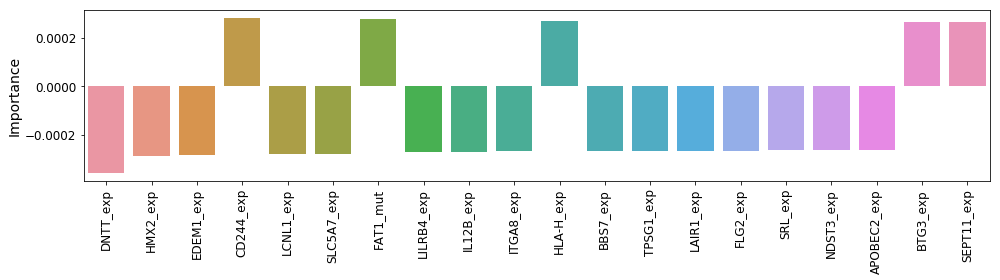

In [109]:
drug_name = "Methotrexate"
drug_id = 1008
drug_tuple = (drug_name, drug_id)

coefs = (gw_exp_vs_all_res.grids[drug_tuple][1].best_estimator_.named_steps["estimator"].coef_)
names = list(X_train_exp_mut.columns)

print(len(coefs), len(names))

sorted_importances = ModelingResults.sort_feature_importances(coefs, names, map_ensembl_to_hgnc)
print(sorted_importances[:5])

# Plot top k features along with their importances
k = 20

xs = [x[0] for x in sorted_importances[:k]]
ys = [x[1] for x in sorted_importances[:k]]

fig = plt.figure(figsize=(14, 4))
ax = sns.barplot(x=xs, y=ys)

ax.tick_params(axis="x", rotation=90, labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_ylabel("Importance", fontsize=14)

plt.tight_layout()
plt.savefig("/home/krzysztof/Pulpit/doktorat_stuff/trametinib_feat_imp_all.pdf")

plt.show()

17737 17737
[('DNTT_exp', -0.0003664151073703045), ('EDEM1_exp', -0.0002895570141265616), ('HMX2_exp', -0.00028830626589441564), ('LCNL1_exp', -0.00028826906430384926), ('CD244_exp', 0.0002856091768774106)]


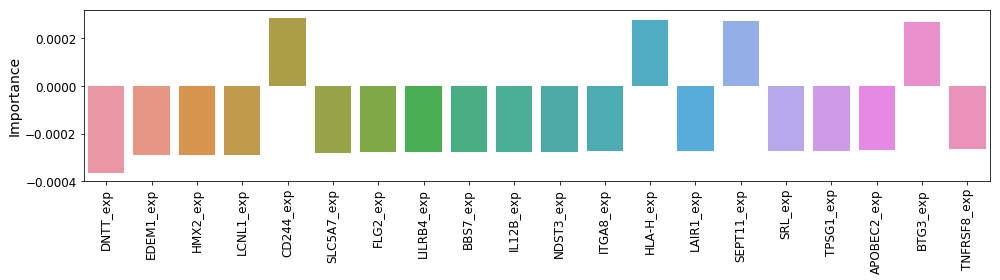

In [110]:
drug_name = "Methotrexate"
drug_id = 1008
drug_tuple = (drug_name, drug_id)

coefs = (gw_exp_vs_all_res.grids[drug_tuple][0].best_estimator_.named_steps["estimator"].coef_)
names = list(X_train_exp.columns)

print(len(coefs), len(names))

sorted_importances = ModelingResults.sort_feature_importances(coefs, names, map_ensembl_to_hgnc)
print(sorted_importances[:5])

# Plot top k features along with their importances
k = 20

xs = [x[0] for x in sorted_importances[:k]]
ys = [x[1] for x in sorted_importances[:k]]

fig = plt.figure(figsize=(14, 4))
ax = sns.barplot(x=xs, y=ys)

ax.tick_params(axis="x", rotation=90, labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_ylabel("Importance", fontsize=14)

plt.tight_layout()
#plt.savefig("/home/krzysztof/Pulpit/doktorat_stuff/trametinib_feat_imp_restricted.pdf")

plt.show()

## Feature importances from best restricted models per drug

In [13]:
df_best_from_restricted = pd.read_csv("Results and other files/df_best_results_per_drug_from_restricted_models.csv")
print(df_best_from_restricted.shape, df_best_from_restricted["Drug ID"].nunique())
df_best_from_restricted.head(3)

(177, 9) 177


,Drug ID,Drug Name,Model test RMSE,Model test correlation,Correlation pval,Dummy test RMSE,Relative test RMSE,Target Pathway,Model
0,1373,Dabrafenib,0.127750,0.752645,1.075014e-40,0.193280,1.514006,ERK MAPK signaling,OT + S RF
1,277,Linifanib,0.055801,0.749668,4.346970e-19,0.080856,1.483354,RTK signaling,OT RF
2,52,GNF-2,0.043907,0.698448,2.000000e-01,0.053700,1.246686,ABL signaling,OT EN


Quartiles: 0.2622708126833572 0.3887739838662254 0.5092078812914395


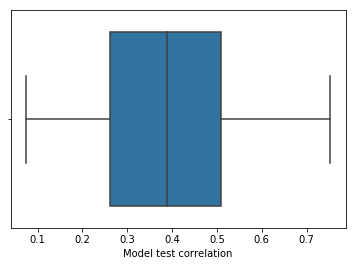

In [14]:
# Plot distribution of best restricted results
print("Quartiles:",
      np.quantile(df_best_from_restricted["Model test correlation"], 0.25),
      np.quantile(df_best_from_restricted["Model test correlation"], 0.5),
      np.quantile(df_best_from_restricted["Model test correlation"], 0.75))
      
sns.boxplot(x=df_best_from_restricted["Model test correlation"])

plt.show()

In [15]:
# Counts of models among best restricted
df_best_from_restricted.Model.value_counts()

PG + S EN    37
PG + S RF    31
OT + S EN    29
OT + S RF    24
PG EN        24
PG RF        13
OT RF        11
OT EN         8
Name: Model, dtype: int64

In [16]:
# Load a dictionary with feature importances vectors
with open("Results and other files/feature_importances_from_best_restricted_model_per_drug.pkl", "rb") as f:
    feat_imps_best_restr_models = dill.load(f)
print(type(feat_imps_best_restr_models), len(feat_imps_best_restr_models))

<class 'dict'> 177


In [69]:
# Get top k performances
k = 57
df_topk_restricted = df_best_from_restricted.iloc[:k]

topk_feats = 1
top_feature_types = {"tissue": 0,
                    "expression": 0,
                    "mutation": 0,
                    "signatures": 0,
                    "CNV": 0}

# Check feature types in top k drugs
drugs_with_all_feats = 0
drugs_with_three_feats = 0
drugs_with_signatures = 0
for idx, row in df_topk_restricted.iterrows():
    name = row["Drug Name"]
    ide = row["Drug ID"]
    corr = row["Model test correlation"]
    tp = row["Target Pathway"]
    
    feat_names = [x[0] for x in feat_imps_best_restr_models[(name, ide)].importances_vector]
    feat_types = ModelingResults.check_feature_types(feat_names)
    if {"expression", "mutation", "CNV", "signatures", "tissue"} <= feat_types:
        drugs_with_all_feats += 1
#         top_feats = feat_names[:topk_feats]
#         for feat_type in top_feature_types:
#             if {feat_type} <= ModelingResults.check_feature_types(top_feats):
#                 top_feature_types[feat_type] += 1
        
    if {"expression", "mutation", "CNV"} <= feat_types:
        drugs_with_three_feats += 1
        top_feats = feat_names[:topk_feats]
        for feat_type in top_feature_types:
            if {feat_type} <= ModelingResults.check_feature_types(top_feats):
                top_feature_types[feat_type] += 1
                if feat_type not in ["expression", "signatures"]:
                    print(name,",", tp, "|", feat_type)
                
    if {"signatures"} <= feat_types:
        drugs_with_signatures += 1
        

print()
print("Drugs in total:", k)
print("Drugs with all features:", drugs_with_all_feats)
print("Drugs with three features:", drugs_with_three_feats)
print("Drugs with signatures:", drugs_with_signatures)
print("Correlation of last drug:", corr)
print()

print("Top mutations:", top_feature_types["mutation"])
print("Top expressions", top_feature_types["expression"])
print("Top signatures", top_feature_types["signatures"])
print("Top tissue", top_feature_types["tissue"])
print("Top CNV", top_feature_types["CNV"])

df_topk_restricted.Model.value_counts()

Dabrafenib , ERK MAPK signaling | mutation
I-BET-762 , Chromatin other | tissue
PLX-4720 , ERK MAPK signaling | mutation
Methotrexate , DNA replication | tissue
Nutlin-3a (-) , p53 pathway | mutation
AT-7519 , Cell cycle | tissue
Fedratinib , Other, kinases | tissue
SB590885 , ERK MAPK signaling | tissue
THZ-2-49 , Cell cycle | tissue
CP466722 , Genome integrity | tissue
NVP-BHG712 , Other | tissue
JW-7-24-1 , Other, kinases | tissue
CAY10603 , Chromatin histone acetylation | tissue
AR-42 , Chromatin histone acetylation | tissue
QL-XI-92 , Other | tissue
XMD14-99 , Other | tissue
Pelitinib , EGFR signaling | mutation

Drugs in total: 57
Drugs with all features: 27
Drugs with three features: 50
Drugs with signatures: 32
Correlation of last drug: 0.4647821766654358

Top mutations: 4
Top expressions 20
Top signatures 13
Top tissue 13
Top CNV 0


PG EN        10
PG + S EN    10
PG + S RF     8
OT + S EN     8
PG RF         6
OT RF         6
OT + S RF     6
OT EN         3
Name: Model, dtype: int64

## Feature importances all restricted modelings

In [13]:
df_best_from_restricted = pd.read_csv("Results and other files/df_best_results_per_drug_from_restricted_models.csv")
print(df_best_from_restricted.shape, df_best_from_restricted["Drug ID"].nunique())
df_best_from_restricted.head(3)

(177, 9) 177


,Drug ID,Drug Name,Model test RMSE,Model test correlation,Correlation pval,Dummy test RMSE,Relative test RMSE,Target Pathway,Model
0,1373,Dabrafenib,0.127750,0.752645,1.075014e-40,0.193280,1.514006,ERK MAPK signaling,OT + S RF
1,277,Linifanib,0.055801,0.749668,4.346970e-19,0.080856,1.483354,RTK signaling,OT RF
2,52,GNF-2,0.043907,0.698448,2.000000e-01,0.053700,1.246686,ABL signaling,OT EN


In [14]:
with open("Results and other files/feature_importances_all_restricted_modelings.pkl", "rb") as f:
    feat_imps_all_restricted_mods = dill.load(f)
print(len(feat_imps_all_restricted_mods))

177


In [15]:
# Extract data for restricted models with signatures
data_signature_models = df_agg_all_models[
    df_agg_all_models.Model.isin(["OT + S EN", "OT + S RF", "PG + S EN", "PG + S RF"])
]
print(data_signature_models.shape, data_signature_models.Model.nunique())

(704, 9) 4


In [16]:
# Create a dict containing information about models consisting all feature types
models_with_all_feats = {}
sign_mods = ["OT + S EN", "OT + S RF", "PG + S EN", "PG + S RF"]


for name, ide in feat_imps_all_restricted_mods:
    models_with_all = []
    for model in sign_mods:
        if model in feat_imps_all_restricted_mods[(name, ide)]:
            feat_names = [x[0] for x in feat_imps_all_restricted_mods[(name, ide)][model].importances_vector]
            corr = feat_imps_all_restricted_mods[(name, ide)][model].test_correlation
            feat_types = ModelingResults.check_feature_types(feat_names)
            if len(feat_types) == 5:
                models_with_all.append((model, corr))
                
    if len(models_with_all) > 0:
        models_with_all = sorted(models_with_all, key=lambda x: x[1], reverse=True)
        models_with_all_feats[(name, ide)] = models_with_all
        
print("All drugs with restricted models:", len(feat_imps_all_restricted_mods))
print("Drugs with at least one restricted model with all feature types:", len(models_with_all_feats))
print(models_with_all_feats[("Erlotinib", 1)])

All drugs with restricted models: 177
Drugs with at least one restricted model with all feature types: 160
[('OT + S EN', 0.4102571189894932), ('PG + S RF', 0.3916252656462129), ('PG + S EN', 0.3757112401003099), ('OT + S RF', 0.33480861356789704)]


In [17]:
# Make sort drugs with models with all feature types by correlation
ides = []
names = []
models = []
corrs = []

for name, ide in models_with_all_feats:
    ides.append(ide)
    names.append(name)
    models.append(models_with_all_feats[(name, ide)][0][0])
    corrs.append(models_with_all_feats[(name, ide)][0][1])
    
df = pd.DataFrame()
df["Drug ID"] = ides
df["Drug Name"] = names
df["Model"] = models
df["Test correlation"] = corrs

df = df.sort_values("Test correlation", ascending=False).reset_index(drop=True)
print(df.shape)
df.head(3)

(160, 4)


,Drug ID,Drug Name,Model,Test correlation
0,1373,Dabrafenib,OT + S RF,0.752645
1,29,AZ628,OT + S EN,0.665869
2,1372,Trametinib,PG + S EN,0.653570


In [18]:
# Extract feature information about feature importance for top 50 drugs, 
# using only models with all feature types
k = 50
topk_feats = 2
top_feature_types = {"tissue": 0,
                    "expression": 0,
                    "mutation": 0,
                    "signatures": 0,
                    "CNV": 0}
for idx, row in df.iloc[:50].iterrows():
    ide = row["Drug ID"]
    name = row["Drug Name"]
    best_model = row["Model"]
    
    top_feats = feat_imps_all_restricted_mods[(name, ide)][best_model].importances_vector[:topk_feats]
    top_feats = [x[0] for x in top_feats]
   
    for feat_type in top_feature_types:
        top_feature_types[feat_type] += ModelingResults.count_feat_types(top_feats, feat_type)
        
        
print("Last correlation:", df.iloc[k-1]["Test correlation"])
print("Top mutations:", top_feature_types["mutation"])
print("Top expressions", top_feature_types["expression"])
print("Top signatures", top_feature_types["signatures"])
print("Top tissue", top_feature_types["tissue"])
print("Top CNV", top_feature_types["CNV"])

Last correlation: 0.4693335618103786
Top mutations: 6
Top expressions 45
Top signatures 34
Top tissue 14
Top CNV 1


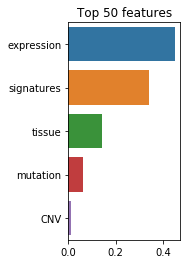

In [19]:
# Plot the counts / frequencies
fig = plt.figure(figsize=(2, 4))
order = ["expression", "signatures", "tissue", "mutation", "CNV"]
xs = []
ys = []
for feat in top_feature_types:
    xs.append(feat)
    ys.append(top_feature_types[feat] / (k * topk_feats))
    
ax = sns.barplot(x=ys, y=xs, order=order, orient="h")

ax.set_title("Top {} features".format(k))

#sns.despine(left=True, bottom=True)

plt.show()

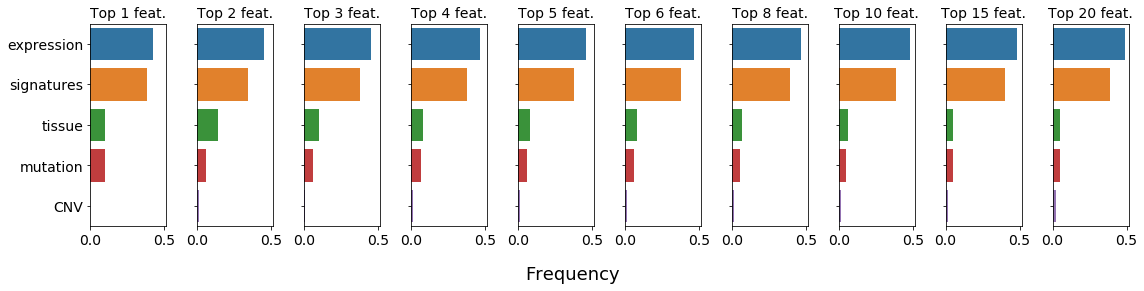

In [27]:
# Plot the counts / frequencies
order = ["expression", "signatures", "tissue", "mutation", "CNV"]


kfeats = [1, 2, 3, 4, 5, 6, 8, 10, 15, 20]
kdrugs = 50
i = 1

for kfeat in kfeats:
    topk_feats = kfeat
    top_feature_types = {"tissue": 0,
                        "expression": 0,
                        "mutation": 0,
                        "signatures": 0,
                        "CNV": 0}
    for idx, row in df.iloc[:kdrugs].iterrows():
        ide = row["Drug ID"]
        name = row["Drug Name"]
        best_model = row["Model"]

        top_feats = feat_imps_all_restricted_mods[(name, ide)][best_model].importances_vector[:topk_feats]
        top_feats = [x[0] for x in top_feats]

        for feat_type in top_feature_types:
            top_feature_types[feat_type] += ModelingResults.count_feat_types(top_feats, feat_type)
            
    xs = []
    ys = []
    
    for feat in top_feature_types:
        xs.append(feat)
        ys.append(top_feature_types[feat] / (kfeat * kdrugs))
        
    ax = fig.add_subplot(1, len(kfeats), i)
    ax.tick_params(axis="both", labelsize=14)
    sns.barplot(x=ys, y=xs, order=order, orient="h", ax=ax)
    ax.set_title("Top {} feat.".format(kfeat), fontsize=14)
    ax.set_xlim((0.0, 0.51345))
    if i != 1:
        ax.set_yticklabels(["" for x in range(len(ax.get_yticklabels()))])
    
    i += 1
    
fig.text(0.5, 0.00, 'Frequency', ha='center', va="bottom", fontsize=18)
#sns.despine(left=True, bottom=True)
plt.tight_layout()
fig.subplots_adjust(bottom=0.2) # or whatever

plt.savefig("/home/krzysztof/Dokumenty/Doktorat/Dokumenty/Plakat Ascona/Panels/fig5_poster_feat_importances.pdf")

plt.show()

In [26]:
ax.get_xlim()

(0.0, 0.51345)

## Overall results between methods - filtered

In [13]:
df_agg_all_models_filtered.head(3)

,Drug ID,Drug Name,Model test RMSE,Model test correlation,Correlation pval,Dummy test RMSE,Relative test RMSE,Target Pathway,Model
0,1,Erlotinib,0.086347,0.388664,0.001450,0.0924,1.075011,EGFR signaling,OT EN
1,1,Erlotinib,0.086797,0.356010,0.000767,0.0924,1.062901,EGFR signaling,PG EN
2,1,Erlotinib,0.086307,0.375711,0.000364,0.0924,1.071611,EGFR signaling,PG + S EN


In [14]:
# Inlude only drugs present for all methods
df_agg_intersection = df_agg_all_models_filtered[
    df_agg_all_models_filtered["Drug ID"].isin(drug_intersection)
]
print(df_agg_all_models_filtered.shape, df_agg_intersection.shape)

(2232, 9) (1944, 9)


In [15]:
df_agg_intersection.Model.nunique()

12

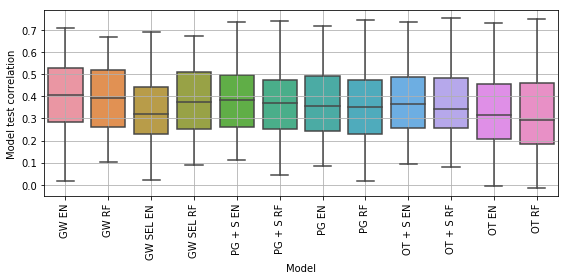

In [16]:
plt.figure(figsize=(8, 4))

order = ["GW EN", "GW RF", "GW SEL EN", "GW SEL RF", "PG + S EN", "PG + S RF", "PG EN", "PG RF",
        "OT + S EN", "OT + S RF", "OT EN", "OT RF"]

ax = sns.boxplot(x="Model", y="Model test correlation", data=df_agg_intersection,
                order=order)

plt.xticks(rotation=90)
plt.grid()

plt.tight_layout()

plt.show()

In [17]:
# Perform statistical test for figure above
# Perform tests
from scipy.stats import mannwhitneyu,ttest_ind
test_dict = {}

reference = df_agg_intersection[
    df_agg_intersection.Model == "GW EN"
]["Model test correlation"].values

for method in df_agg_intersection.Model.unique():
    if method not in ["GW EN", "GW RF"]:
        # Extract correlation
        corrs = df_agg_intersection[
    df_agg_intersection.Model == method]["Model test correlation"].values
        pval = ttest_ind(reference, corrs, equal_var=False)[1]
        print(method, pval)


## Results per drug for all methods - filtered

In [18]:
print(df_agg_all_models_filtered["Drug ID"].nunique(), 
      df_agg_all_models_filtered["Drug Name"].nunique(),
      df_agg_all_models_filtered["Model"].nunique())
df_agg_all_models_filtered.head()

232 232 12


,Drug ID,Drug Name,Model test RMSE,Model test correlation,Correlation pval,Dummy test RMSE,Relative test RMSE,Target Pathway,Model
0,1,Erlotinib,0.086347,0.388664,0.001450,0.0924,1.075011,EGFR signaling,OT EN
1,1,Erlotinib,0.086797,0.356010,0.000767,0.0924,1.062901,EGFR signaling,PG EN
2,1,Erlotinib,0.086307,0.375711,0.000364,0.0924,1.071611,EGFR signaling,PG + S EN
3,1,Erlotinib,0.087412,0.334809,0.003335,0.0924,1.059982,EGFR signaling,OT + S RF
4,1,Erlotinib,0.085563,0.391625,0.000803,0.0924,1.081329,EGFR signaling,PG + S RF


In [19]:
# Establish order of the drugs
drug_scores = []
drugs_only_gw = []

gw_models = ["GW EN", "GW RF", "GW SEL EN", "GW SEL RF"]
rest_models = ["PG + S EN", "PG + S RF", "PG + S EN", "OT + S EN", "OT + S RF", "OT EN", "OT RF"]
for name in df_agg_all_models_filtered["Drug Name"].unique():
    df = df_agg_all_models_filtered[
        df_agg_all_models_filtered["Drug Name"] ==  name
    ]
    if df.shape[0] == 4:
        score = df.sort_values("Model test correlation", ascending=False).iloc[0]["Model test correlation"]
        drugs_only_gw.append((name, score))
        continue
    else:
        df_gw = df[df.Model.isin(gw_models)]
        df_rest = df[df.Model.isin(rest_models)]
        
        gw_score = df_gw.sort_values("Model test correlation", ascending=False).iloc[0]["Model test correlation"]
        rest_score = df_rest.sort_values("Model test correlation", ascending=False).iloc[0]["Model test correlation"]
        
        diff = gw_score - rest_score
        
        drug_scores.append((name, diff))
        
drug_scores = sorted(drug_scores, key=lambda x: x[1], reverse=True)
drugs_only_gw = sorted(drugs_only_gw, key=lambda x: x[1], reverse=True)
print(len(drug_scores), len(drugs_only_gw))

drug_scores_all = drug_scores + drugs_only_gw
order = [x[0] for x in drug_scores_all]
print(len(order))
        
        
hue_order = ["GW EN", "GW RF", "GW SEL EN", "GW SEL RF", "PG + S EN", "PG + S RF", "PG EN", "PG RF",
        "OT + S EN", "OT + S RF", "OT EN", "OT RF"]

step = 46

164 68
232


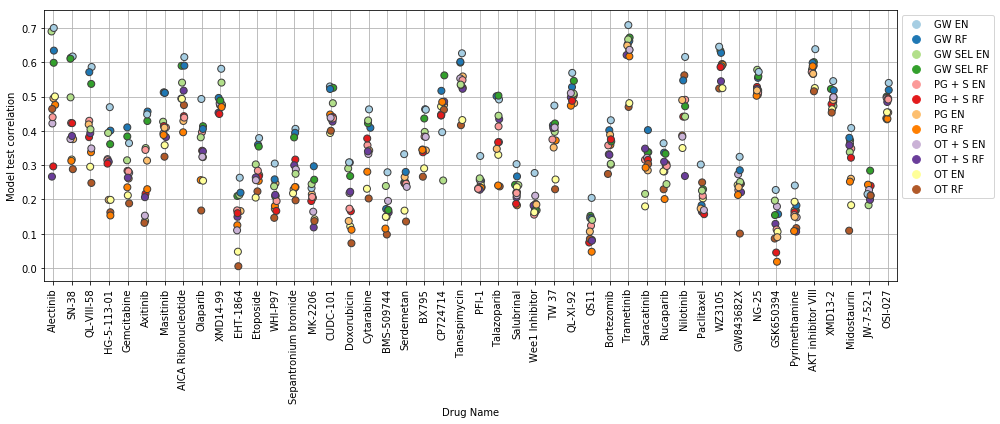

In [20]:
# 1st part
current_names = order[:step]
df = df_agg_all_models_filtered[
    df_agg_all_models_filtered["Drug Name"].isin(current_names)
]

plt.figure(figsize=(14, 6))

ax = sns.stripplot(x="Drug Name", y="Model test correlation", data=df,
                  hue="Model", hue_order=hue_order,
                  order=current_names,
                  palette=sns.color_palette("Paired"),
                  size=7,
                  linewidth=1,
                  jitter=True,
                  dodge=False)

plt.legend(loc="upper left", bbox_to_anchor=(1,1))

plt.xticks(rotation=90)
plt.grid()

plt.tight_layout()

plt.show()

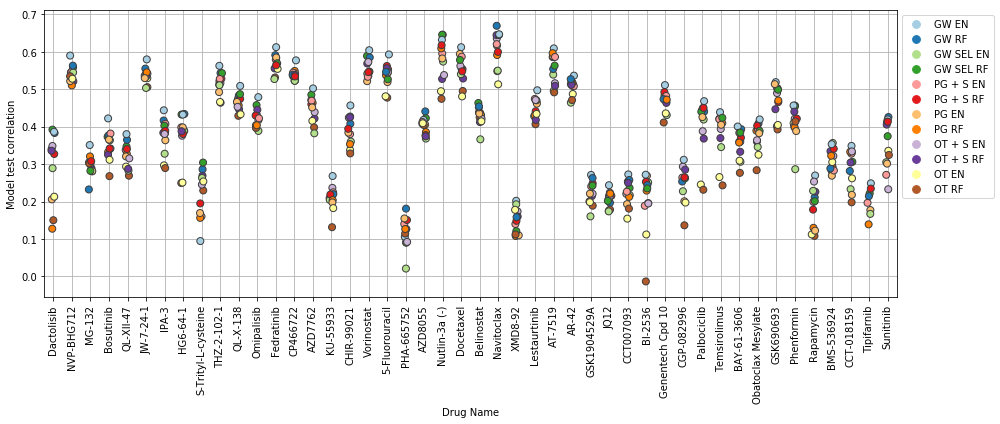

In [21]:
# 2nd part
current_names = order[1 * step: 2*step]
df = df_agg_all_models_filtered[
    df_agg_all_models_filtered["Drug Name"].isin(current_names)
]

plt.figure(figsize=(14, 6))

ax = sns.stripplot(x="Drug Name", y="Model test correlation", data=df,
                  hue="Model", hue_order=hue_order,
                  order=current_names,
                  palette=sns.color_palette("Paired"),
                  size=7,
                  linewidth=1,
                  jitter=True,
                  dodge=False)

plt.legend(loc="upper left", bbox_to_anchor=(1,1))

plt.xticks(rotation=90)
plt.grid()

plt.tight_layout()

plt.show()

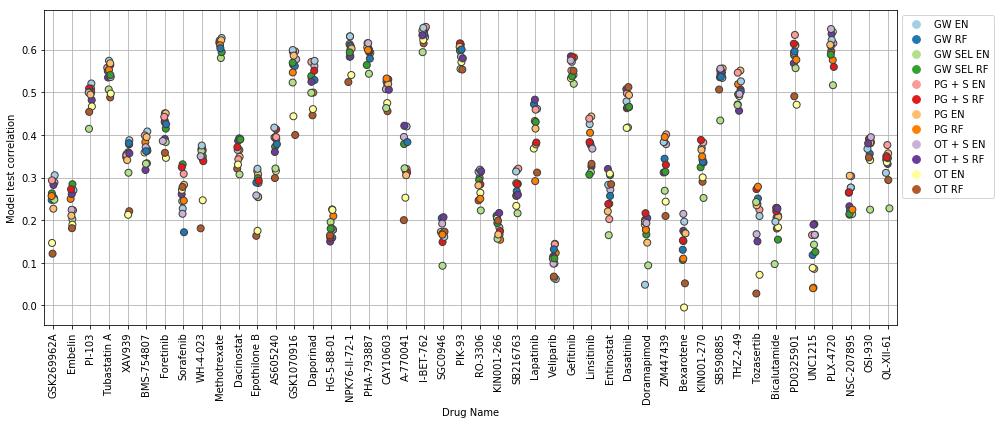

In [22]:
# 3rd part
current_names = order[2 * step: 3*step]
df = df_agg_all_models_filtered[
    df_agg_all_models_filtered["Drug Name"].isin(current_names)
]

plt.figure(figsize=(14, 6))

ax = sns.stripplot(x="Drug Name", y="Model test correlation", data=df,
                  hue="Model", hue_order=hue_order,
                  order=current_names,
                  palette=sns.color_palette("Paired"),
                  size=7,
                  linewidth=1,
                  jitter=True,
                  dodge=False)

plt.legend(loc="upper left", bbox_to_anchor=(1,1))

plt.xticks(rotation=90)
plt.grid()

plt.tight_layout()

plt.show()

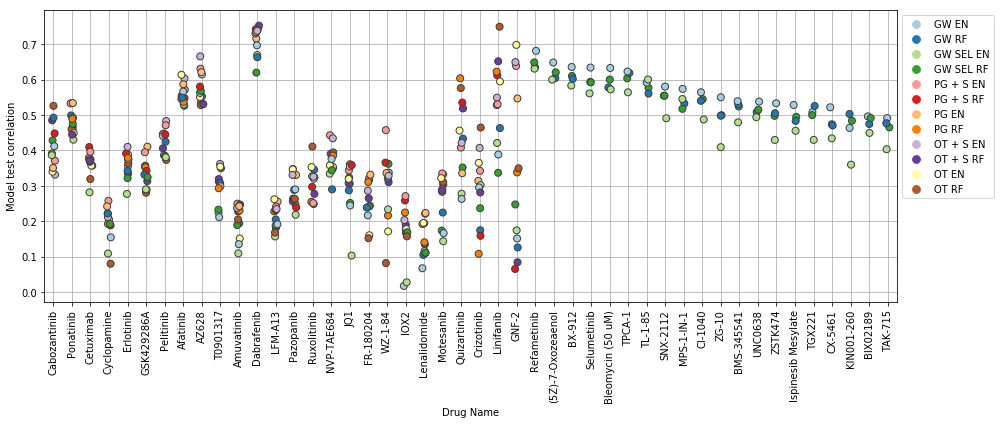

In [23]:
# 4th part
current_names = order[3*step: 4*step]
df = df_agg_all_models_filtered[
    df_agg_all_models_filtered["Drug Name"].isin(current_names)
]

plt.figure(figsize=(14, 6))

ax = sns.stripplot(x="Drug Name", y="Model test correlation", data=df,
                  hue="Model", hue_order=hue_order,
                  order=current_names,
                  palette=sns.color_palette("Paired"),
                  size=7,
                  linewidth=1,
                  jitter=True,
                  dodge=False)

plt.legend(loc="upper left", bbox_to_anchor=(1,1))

plt.xticks(rotation=90)
plt.grid()

plt.tight_layout()

plt.show()

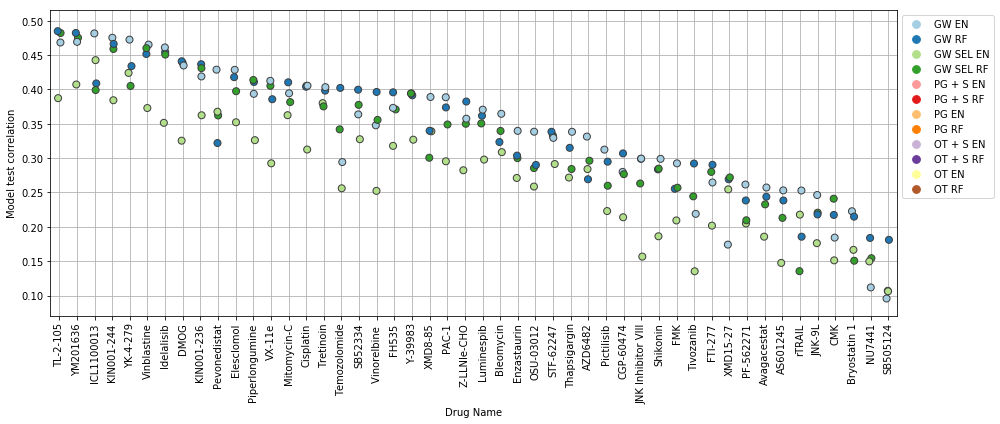

In [24]:
# 5th part
current_names = order[4*step:]
df = df_agg_all_models_filtered[
    df_agg_all_models_filtered["Drug Name"].isin(current_names)
]

plt.figure(figsize=(14, 6))

ax = sns.stripplot(x="Drug Name", y="Model test correlation", data=df,
                  hue="Model", hue_order=hue_order,
                  order=current_names,
                  palette=sns.color_palette("Paired"),
                  size=7,
                  linewidth=1,
                  jitter=True,
                  dodge=False)

plt.legend(loc="upper left", bbox_to_anchor=(1,1))

plt.xticks(rotation=90)
plt.grid()

plt.tight_layout()

plt.show()

## Results per drug for genome-wide and genome-wide with automated feature selection - filtered

In [13]:
print(df_agg_all_models_filtered.Model.unique())
df_agg_all_models_filtered.head(3)

['OT EN' 'PG EN' 'PG + S EN' 'OT + S RF' 'PG + S RF' 'GW SEL EN'
 'OT + S EN' 'GW RF' 'GW SEL RF' 'OT RF' 'GW EN' 'PG RF']


,Drug ID,Drug Name,Model test RMSE,Model test correlation,Correlation pval,Dummy test RMSE,Relative test RMSE,Target Pathway,Model
0,1,Erlotinib,0.086347,0.388664,0.001450,0.0924,1.075011,EGFR signaling,OT EN
1,1,Erlotinib,0.086797,0.356010,0.000767,0.0924,1.062901,EGFR signaling,PG EN
2,1,Erlotinib,0.086307,0.375711,0.000364,0.0924,1.071611,EGFR signaling,PG + S EN


In [65]:
# Establish order of the drugs
gw_models = ["GW EN", "GW RF"]
gw_sel_models = ["GW SEL EN", "GW SEL RF"]

scores = []

for drug_name in df_agg_all_models_filtered["Drug Name"].unique():
    df = df_agg_all_models_filtered[
        df_agg_all_models_filtered["Drug Name"] == drug_name
    ]
    df_gw = df[df.Model.isin(gw_models)]
    df_gw_sel = df[df.Model.isin(gw_sel_models)]
    
    best_gw_score = df_gw.sort_values("Model test correlation", ascending=False)["Model test correlation"].iloc[0]
    best_sel_score = df_gw_sel.sort_values("Model test correlation", ascending=False)["Model test correlation"].iloc[0]
    
    diff = (best_sel_score - best_gw_score) / best_gw_score
    scores.append((drug_name, diff))
    
print(len(scores))
scores = sorted(scores, reverse=True, key=lambda x: x[1])
print(scores[:5])
order = [x[0] for x in scores]
print(order[:5])

232
[('GNF-2', 0.6343735604149838), ('Sorafenib', 0.456228851768325), ('JW-7-52-1', 0.3168736748803262), ('CMK', 0.1086856696314957), ('Lenalidomide', 0.1034329784384498)]
['GNF-2', 'Sorafenib', 'JW-7-52-1', 'CMK', 'Lenalidomide']


In [73]:
# Constants
step = 46
hue_order = ["GW EN", "GW RF", "GW SEL EN", "GW SEL RF"]
# Colors
color_list = sns.color_palette("Paired", n_colors=6)
color_list = color_list[2:]

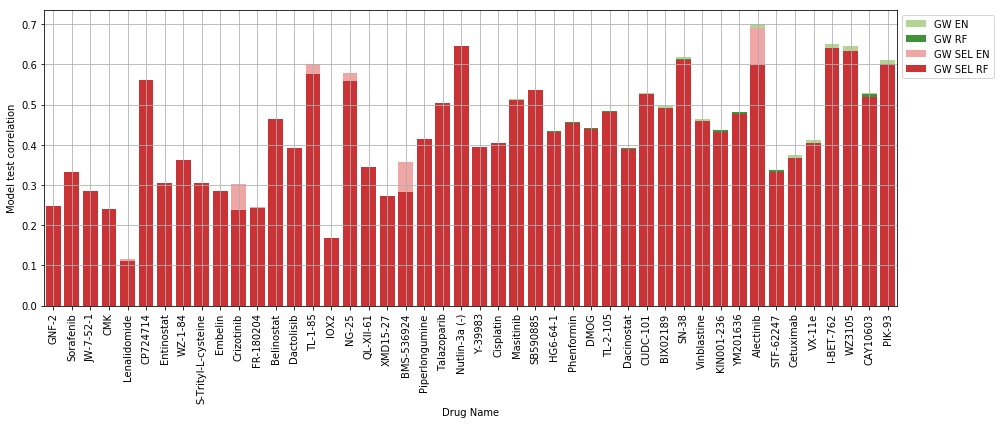

In [81]:
# 1st part
current_names = order[:step]
df = df_agg_all_models_filtered[
    df_agg_all_models_filtered["Drug Name"].isin(current_names)
]

plt.figure(figsize=(14, 6))

ax = sns.barplot(x="Drug Name", y="Model test correlation", data=df,
                  hue="Model", hue_order=hue_order,
                  order=current_names,
                  palette=color_list,
                  linewidth=1,
                  dodge=False,
                  alpha=1.)

plt.legend(loc="upper left", bbox_to_anchor=(1,1))

plt.xticks(rotation=90)
plt.grid()

plt.tight_layout()

plt.show()

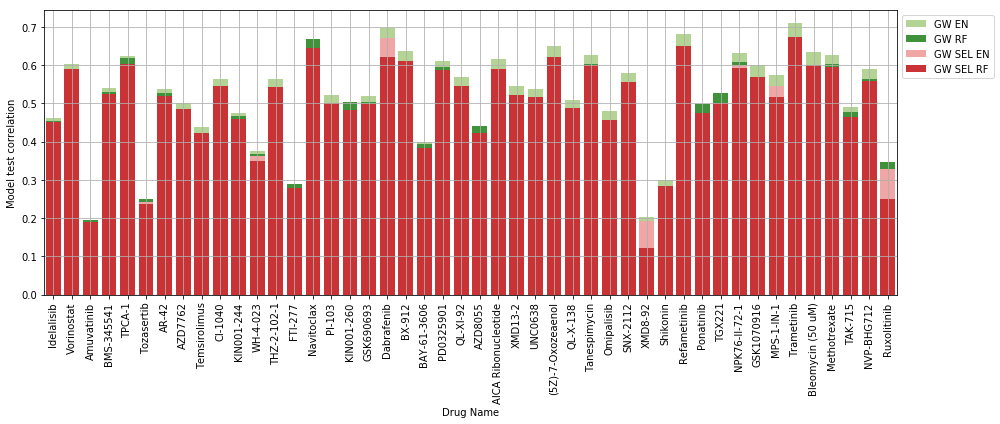

In [75]:
# 2nd part
current_names = order[step:step * 2]
df = df_agg_all_models_filtered[
    df_agg_all_models_filtered["Drug Name"].isin(current_names)
]

plt.figure(figsize=(14, 6))

ax = sns.barplot(x="Drug Name", y="Model test correlation", data=df,
                  hue="Model", hue_order=hue_order,
                  order=current_names,
                  palette=color_list,
                  linewidth=1,
                  dodge=False)

plt.legend(loc="upper left", bbox_to_anchor=(1,1))

plt.xticks(rotation=90)
plt.grid()

plt.tight_layout()

plt.show()

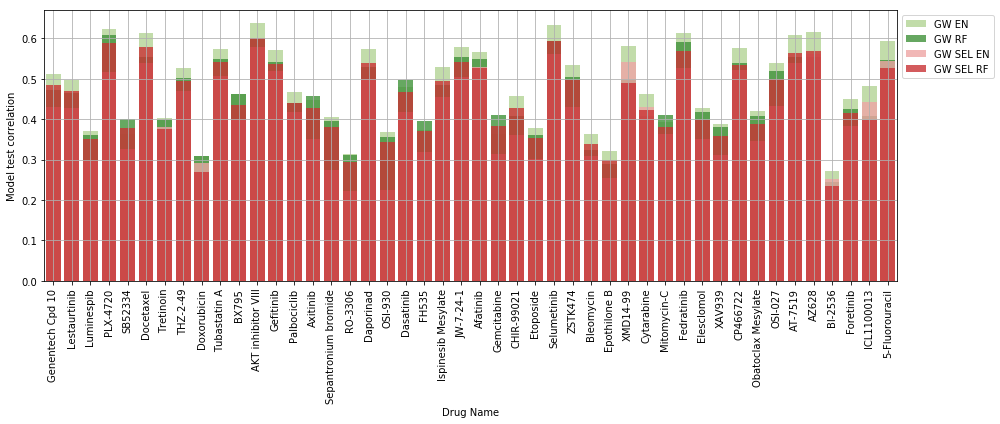

In [78]:
# 3rd part
current_names = order[2 * step:step * 3]
df = df_agg_all_models_filtered[
    df_agg_all_models_filtered["Drug Name"].isin(current_names)
]

plt.figure(figsize=(14, 6))

ax = sns.barplot(x="Drug Name", y="Model test correlation", data=df,
                  hue="Model", hue_order=hue_order,
                  order=current_names,
                  palette=color_list,
                  linewidth=1,
                  alpha=0.8,
                dodge=False)

plt.legend(loc="upper left", bbox_to_anchor=(1,1))

plt.xticks(rotation=90)
plt.grid()

plt.tight_layout()

plt.show()

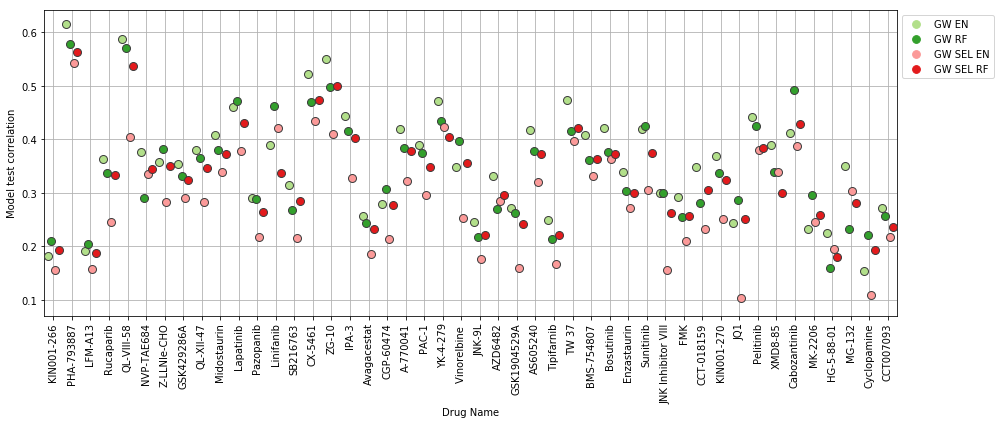

In [77]:
# 4th part
current_names = order[3 * step:step * 4]
df = df_agg_all_models_filtered[
    df_agg_all_models_filtered["Drug Name"].isin(current_names)
]

plt.figure(figsize=(14, 6))

ax = sns.stripplot(x="Drug Name", y="Model test correlation", data=df,
                  hue="Model", hue_order=hue_order,
                  order=current_names,
                  palette=color_list,
                  size=8,
                  linewidth=1,
                  dodge=True)

plt.legend(loc="upper left", bbox_to_anchor=(1,1))

plt.xticks(rotation=90)
plt.grid()

plt.tight_layout()

plt.show()

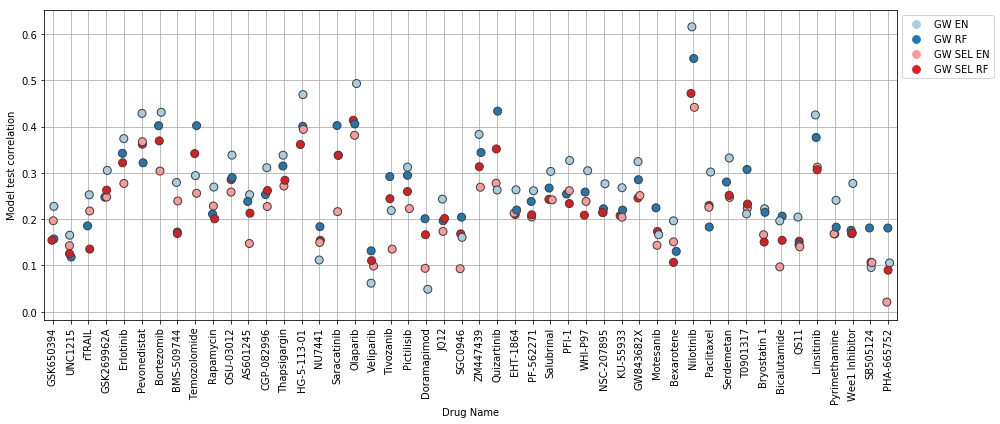

In [20]:
# 5th part
current_names = order[4 * step:]
df = df_agg_all_models_filtered[
    df_agg_all_models_filtered["Drug Name"].isin(current_names)
]

plt.figure(figsize=(14, 6))

ax = sns.stripplot(x="Drug Name", y="Model test correlation", data=df,
                  hue="Model", hue_order=hue_order,
                  order=current_names,
                  palette=color_list,
                  size=8,
                  linewidth=1,
                  dodge=False)

plt.legend(loc="upper left", bbox_to_anchor=(1,1))

plt.xticks(rotation=90)
plt.grid()

plt.tight_layout()

plt.show()

## Results per drug: Random Forest and Random Forest with automated feature selection

In [142]:
# Establish order of the drugs
scores = []

for drug_name in df_agg_all_models_filtered["Drug Name"].unique():
    df = df_agg_all_models_filtered[
        df_agg_all_models_filtered["Drug Name"] == drug_name
    ]
    df_gw = df[df.Model == "GW RF"]
    df_gw_sel = df[df.Model == "GW SEL RF"]
    
    best_gw_score = df_gw.sort_values("Model test correlation", ascending=False)["Model test correlation"].iloc[0]
    best_sel_score = df_gw_sel.sort_values("Model test correlation", ascending=False)["Model test correlation"].iloc[0]
    
    best_score = max(best_gw_score, best_sel_score)
    scores.append((drug_name, best_score))
    
print(len(scores))
scores = sorted(scores, reverse=True, key=lambda x: x[1])
print(scores[:5])
order = [x[0] for x in scores]
print(order[:5])

232
[('Trametinib', 0.6724797799871947), ('Navitoclax', 0.6692912124048555), ('Dabrafenib', 0.66347676479851), ('Refametinib', 0.6488897086505945), ('Nutlin-3a (-)', 0.6454222851172565)]
['Trametinib', 'Navitoclax', 'Dabrafenib', 'Refametinib', 'Nutlin-3a (-)']


In [143]:
# Constants
step = 46
hue_order = ["GW RF", "GW SEL RF"]

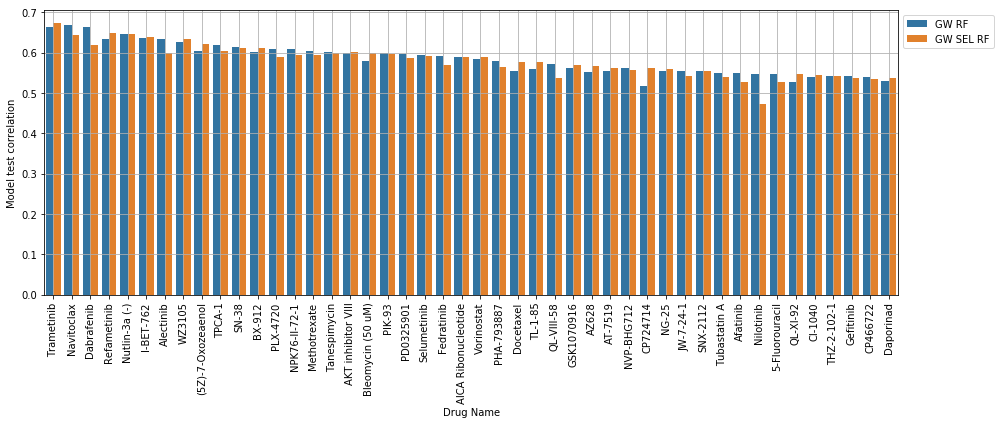

In [144]:
# 1st part
current_names = order[:step]
df = df_agg_all_models_filtered[
    df_agg_all_models_filtered["Drug Name"].isin(current_names)
]

plt.figure(figsize=(14, 6))

ax = sns.barplot(x="Drug Name", y="Model test correlation", data=df,
                  hue="Model", hue_order=hue_order,
                  order=current_names,
                  linewidth=1,
                  dodge=True)

plt.legend(loc="upper left", bbox_to_anchor=(1,1))

plt.xticks(rotation=90)
plt.grid()

plt.tight_layout()

plt.show()

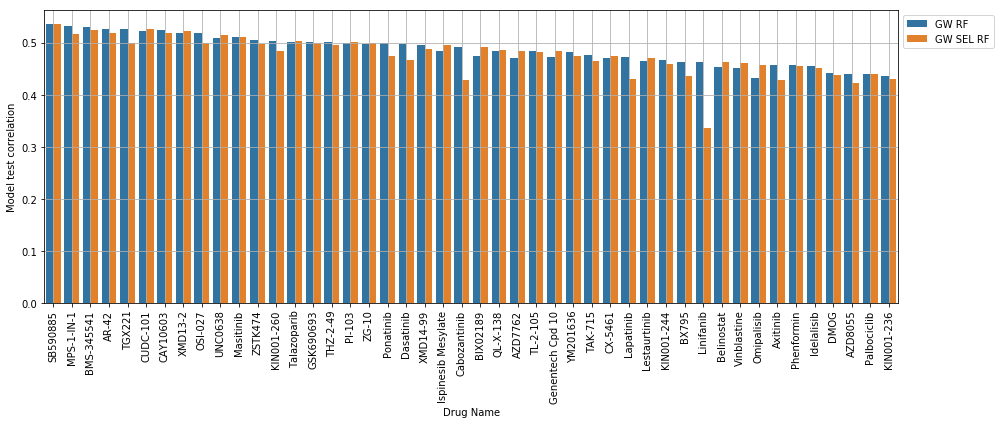

In [146]:
# 2nd part
current_names = order[step:step * 2]
df = df_agg_all_models_filtered[
    df_agg_all_models_filtered["Drug Name"].isin(current_names)
]

plt.figure(figsize=(14, 6))

ax = sns.barplot(x="Drug Name", y="Model test correlation", data=df,
                  hue="Model", hue_order=hue_order,
                  order=current_names,
                  linewidth=1,
                  dodge=True)

plt.legend(loc="upper left", bbox_to_anchor=(1,1))

plt.xticks(rotation=90)
plt.grid()

plt.tight_layout()

plt.show()

#### Same plot for drugs where the best model was RForest

In [130]:
# Data preparation
exps = ["GW RF", "GW SEL RF"]

df = df_best_results_filtered[
    df_best_results_filtered["Corresponding experiment"].isin(exps)]

order = list(df.sort_values("Model test correlation", ascending=False)["Drug Name"])
ides = df["Drug ID"].unique()

df = df_agg_all_models_filtered[
    df_agg_all_models_filtered.Model.isin(exps) & df_agg_all_models_filtered["Drug ID"].isin(ides)
]

df = df[df["Drug Name"].isin(order)]
print(df.shape)
df.head(2)

(82, 9)


,Drug ID,Drug Name,Model test RMSE,Model test correlation,Correlation pval,Dummy test RMSE,Relative test RMSE,Target Pathway,Model
26,5,Sunitinib,0.127208,0.425643,0.000178,0.138563,1.086363,RTK signaling,GW RF
33,5,Sunitinib,0.133216,0.374412,0.004185,0.138563,1.038895,RTK signaling,GW SEL RF


Extract number of features for displayed drugs

In [123]:
# Load data with numbers of features
data_shapes_df = pd.read_csv("Results and other files/data_shapes_per_drug_in_models.csv")
print(data_shapes_df.shape)
print(data_shapes_df.Model.unique())
data_shapes_rf = data_shapes_df[data_shapes_df.Model == "Genome wide RForest"]
print(data_shapes_rf.shape)
data_shapes_rf.head(2)

(1206, 5)
['Genome wide ENet' 'Genome wide RForest' 'Only targets'
 'Only targets with signatures' 'Pathway genes'
 'Pathway genes with signatures']
(251, 5)


,Drug ID,Drug Name,Model,No. features,No. samples
1,1,Erlotinib,Genome wide RForest,50,370
7,3,Rapamycin,Genome wide RForest,30,362


In [124]:
# Create a list with corresponding number of features
numbers_of_feats = []
for drug_name in order:
    feat_num = data_shapes_rf[data_shapes_rf["Drug Name"] == drug_name]["No. features"].iloc[0]
    numbers_of_feats.append(feat_num)
print(len(numbers_of_feats))

41


In [125]:
# DataFrame with resulst for GW RForest with selection
results_rf_sel = df_agg_all_models_filtered[
    df_agg_all_models_filtered["Model"] == "GW SEL RF"
]
print(results_rf_sel.shape)
results_rf_sel.head(2)

(232, 9)


,Drug ID,Drug Name,Model test RMSE,Model test correlation,Correlation pval,Dummy test RMSE,Relative test RMSE,Target Pathway,Model
8,1,Erlotinib,0.073975,0.321948,0.003384,0.073378,0.983917,EGFR signaling,GW SEL RF
18,3,Rapamycin,0.228970,0.200927,0.084048,0.229805,1.003779,PI3K/MTOR signaling,GW SEL RF


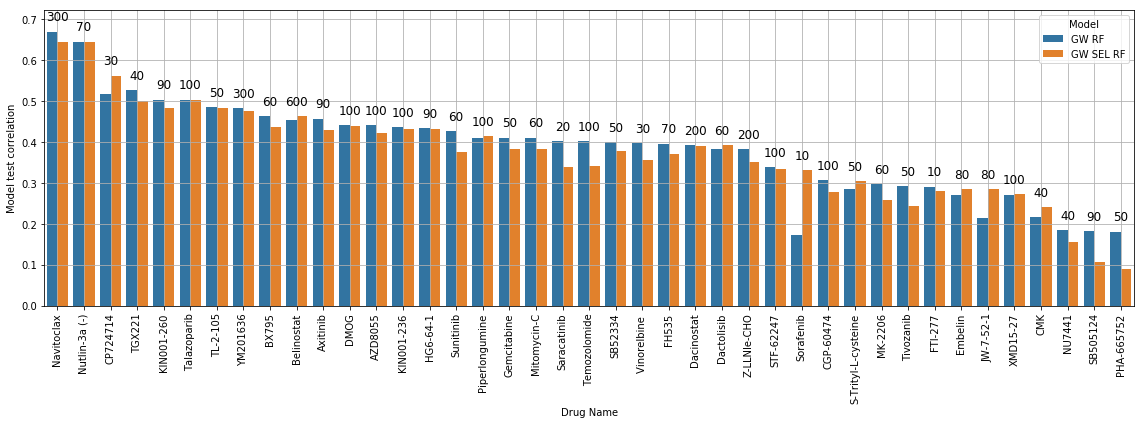

In [139]:
# Do the plotting
plt.figure(figsize=(16, 6))

ax = sns.barplot(x="Drug Name", y="Model test correlation", data=df,
                hue="Model", order=order, hue_order=["GW RF", "GW SEL RF"])

# Add feature numbers

# Constants
vertical_distance = 0.02
text_color = "black"
text_size = 12

for i in range(len(order)):
    drug_name = order[i]
    ymax = df[df["Drug Name"] == drug_name]["Model test correlation"].max()
    feat_number = numbers_of_feats[i]
    
    # Determine x and y coordinates
    x = ax.get_xticks()[i]
    y = ymax + vertical_distance
    ax.text(x, y, feat_number, ha="center", va="bottom", color=text_color, fontsize=text_size)

ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1] + 0.02)

plt.xticks(rotation=90)
plt.grid()

plt.tight_layout()

plt.show()

## Results grouped by pathways - only on intersection, picking only one best result from each group per drug

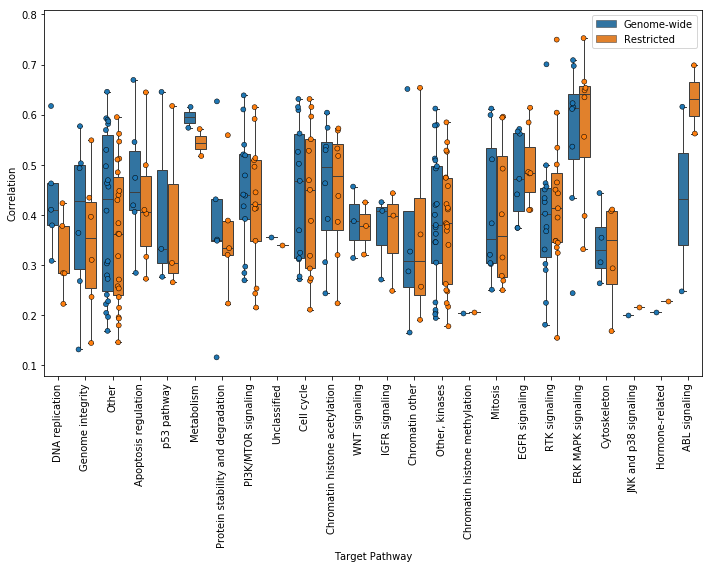

In [14]:
# Establish order of the pathways
differences = []

for tp in df_best_results_from_two_groups_filtered["Target Pathway"].unique():
    df = df_best_results_from_two_groups_filtered[
        df_best_results_from_two_groups_filtered["Target Pathway"] == tp
    ]
    df = df.groupby("Model", as_index=False).agg(np.median)
    gw_corr = df[df.Model == "Genome-wide"]["Model test correlation"].iloc[0]
    restricted_corr = df[df.Model == "Restricted"]["Model test correlation"].iloc[0]
    diff = gw_corr - restricted_corr
    differences.append((tp, diff / gw_corr))

differences = sorted(differences, key=lambda x: x[1], reverse=True)
order = [x[0] for x in differences]

plt.figure(figsize=(10, 8))

ax = sns.boxplot(x="Target Pathway", y="Model test correlation", 
                   data=df_best_results_from_two_groups_filtered,
                 hue="Model",
                 linewidth=1.,
                 fliersize=0.0,
                 dodge=True,
                 order=order,
                 hue_order = ["Genome-wide", "Restricted"])

sns.stripplot(x="Target Pathway", y="Model test correlation", 
                   data=df_best_results_from_two_groups_filtered,
                   hue="Model",
                   dodge=True,
                   linewidth=0.5,
                   jitter=True,
                   edgecolor="black",
                   size=5.,
                   order=order,
                   hue_order = ["Genome-wide", "Restricted"],
                   ax=ax)


# Get the handles and labels. For this example it'll be 2 tuples
# of length 4 each.
handles, labels = ax.get_legend_handles_labels()
ax.set_ylabel("Correlation")
ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1] + 0.02)


l = plt.legend(handles[0:2], labels[0:2], loc="best")

plt.xticks(rotation=90)

plt.tight_layout()

plt.show()

## Results grouped by pathways with statistical tests - all methods, not just picking one from each group

In [107]:
# Load DataFrame with aggregated results for all drugs, with models classified to two groups
df_restricted_vs_gw = pd.read_csv("./Results and other files/df_agg_all_drugs_restricted_vs_genome_wide.csv")
print(df_restricted_vs_gw.shape, df_restricted_vs_gw["Drug ID"].nunique(), df_restricted_vs_gw["Model"].nunique())
df_restricted_vs_gw_filtered = df_restricted_vs_gw[~df_restricted_vs_gw["Drug ID"].isin(bad_drugs)]
print(df_restricted_vs_gw_filtered["Drug ID"].nunique())
df_restricted_vs_gw_filtered.sample(5)

(2412, 9) 251 2
232


,Drug ID,Drug Name,Model test RMSE,Model test correlation,Correlation pval,Dummy test RMSE,Relative test RMSE,Target Pathway,Model
26,5,Sunitinib,0.127208,0.425643,1.779351e-04,0.138563,1.086363,RTK signaling,Genome-wide
36,6,PHA-665752,0.063821,0.020886,4.809608e-01,0.055751,0.872295,RTK signaling,Genome-wide
1993,1069,EHT-1864,0.039574,0.168269,6.935765e-02,0.039698,1.003004,Cytoskeleton,Restricted
2069,1149,TW 37,0.150199,0.397283,4.083920e-11,0.156468,1.041646,Apoptosis regulation,Genome-wide
397,111,Salubrinal,0.062779,0.211947,5.665854e-02,0.064028,1.020324,Other,Restricted


In [123]:
df_restricted_vs_gw["Drug ID"].nunique()

251

In [126]:
# Find drugs only modeled by genome-wide methods
drugs_only_modeled_by_gw = []
for drug_id in df_restricted_vs_gw["Drug ID"].unique():
    df = df_restricted_vs_gw[df_restricted_vs_gw["Drug ID"] == drug_id]
    if df.shape[0] == 4:
        drugs_only_modeled_by_gw.append(drug_id)
print(len(drugs_only_modeled_by_gw))

74


In [127]:
# Compute results at intersection
df_restricted_vs_gw_filtered_intersection = df_restricted_vs_gw_filtered[
    ~df_restricted_vs_gw_filtered["Drug ID"].isin(drugs_only_modeled_by_gw)
]
print(df_restricted_vs_gw_filtered_intersection["Drug ID"].nunique())

164


In [166]:
df_restricted_vs_gw_intersection = df_restricted_vs_gw[
    ~df_restricted_vs_gw["Drug ID"].isin(drugs_only_modeled_by_gw)
]
print(df_restricted_vs_gw_intersection["Drug ID"].nunique())

177


In [170]:
# Establish dataset to plot
data = df_restricted_vs_gw_filtered_intersection
print(data["Drug ID"].nunique())

164


In [171]:
# Perform tests
from scipy.stats import mannwhitneyu


def stars(p):
    if p < 0.0001:
       return "****"
    elif (p < 0.001):
       return "***"
    elif (p < 0.01):
       return "**"
    elif (p < 0.05):
       return "*"
    else:
       return "ns"

# Initialize dictionary with target pathways and corresponding significance tests
significance_dict = {}

for tp in data["Target Pathway"].unique():
    df = data[
        data["Target Pathway"] == tp
    ]
    x = df[df.Model == "Genome-wide"]["Model test correlation"]
    y = df[df.Model == "Restricted"]["Model test correlation"]
    
    p = mannwhitneyu(x, y)[1]
    print(tp, x.shape, y.shape, p)
    
    significance_dict[tp] = p
print(len(significance_dict))

EGFR signaling (28,) (56,) 0.1607030839165891
PI3K/MTOR signaling (52,) (104,) 0.09380513026167747
RTK signaling (60,) (120,) 0.2488200557187913
Protein stability and degradation (20,) (40,) 0.4039796935907516
Mitosis (32,) (64,) 0.12906033734276717
Other (92,) (180,) 0.021302511304851383
ERK MAPK signaling (32,) (64,) 0.4891491357179047
ABL signaling (8,) (16,) 0.22199718801150475
Cell cycle (52,) (104,) 0.1790002986654879
Other, kinases (84,) (168,) 0.1024464141630021
Chromatin histone acetylation (32,) (64,) 0.33310588102256267
DNA replication (24,) (44,) 1.1108256989329505e-05
Hormone-related (4,) (8,) 0.025399260369419956
Genome integrity (24,) (48,) 0.08383938271579178
Apoptosis regulation (24,) (48,) 0.04109970433892837
Cytoskeleton (16,) (32,) 0.19382620871642836
IGFR signaling (12,) (24,) 0.40064284781343484
p53 pathway (12,) (24,) 0.26735924476394995
Chromatin other (16,) (32,) 0.35910118321361284
Metabolism (8,) (16,) 0.0022029844239215956
WNT signaling (12,) (24,) 0.1377181

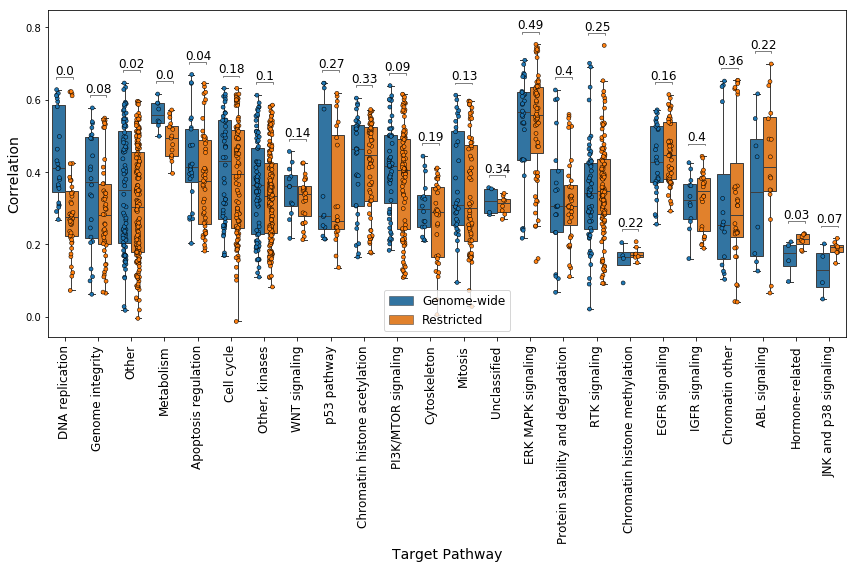

In [173]:
# Establish order of the pathways
differences = []

for tp in data["Target Pathway"].unique():
    df = data[
        data["Target Pathway"] == tp
    ]
    df = df.groupby("Model", as_index=False).agg(np.median)
    gw_corr = df[df.Model == "Genome-wide"]["Model test correlation"].iloc[0]
    restricted_corr = df[df.Model == "Restricted"]["Model test correlation"].iloc[0]
    diff = gw_corr - restricted_corr
    differences.append((tp, diff / gw_corr))

differences = sorted(differences, key=lambda x: x[1], reverse=True)
order = [x[0] for x in differences]

############################################
# Actual plotting
############################################

plt.figure(figsize=(12, 8))

ax = sns.boxplot(x="Target Pathway", y="Model test correlation", 
                   data=data,
                 hue="Model",
                 linewidth=1.,
                 fliersize=0.0,
                 dodge=True,
                 order=order,
                 hue_order = ["Genome-wide", "Restricted"])

sns.stripplot(x="Target Pathway", y="Model test correlation", 
                   data=data,
                   hue="Model",
                   dodge=True,
                   linewidth=0.5,
                   jitter=True,
                   edgecolor="black",
                   size=4.,
                   order=order,
                   hue_order = ["Genome-wide", "Restricted"],
                   ax=ax)

##############################################################
# Add significance asterixes
##############################################################

# Constants
vertical_length = 0.005
horizontal_length = 0.5
y_margin = 0.03
linewidth = 0.5
col = "black"
text_color = "black"
text_size = 12

# Determine x and y coordinates

for i in range(len(order)):
    # Determine x and y coordinates
    xs = []
    ys = []
    
    x = ax.get_xticks()[i]
    xs.append(x - horizontal_length / 2)
    xs.append(x - horizontal_length / 2)
    xs.append(x + horizontal_length / 2)
    xs.append(x + horizontal_length / 2)
    
    tp = order[i]
    
    # Get y data
    df = data[
        data["Target Pathway"] == tp
    ]
    
    ymax = df["Model test correlation"].max()
    ys.append(ymax + y_margin)
    ys.append(ymax + y_margin + vertical_length)
    ys.append(ymax + y_margin + vertical_length)
    ys.append(ymax + y_margin)
    
    ax.plot(xs, ys, lw=linewidth, c=col)
    ax.text(x+0.01, ymax + y_margin + vertical_length, round(significance_dict[tp], 2), 
           ha="center", va="bottom", color=text_color, fontsize=text_size)



# Get the handles and labels. For this example it'll be 2 tuples
# of length 4 each.
handles, labels = ax.get_legend_handles_labels()
ax.set_ylabel("Correlation", fontsize=14)
ax.set_xlabel("Target Pathway", fontsize=14)

ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1] + 0.02)

# When creating the legend, only use the first two elements
# to effectively remove the last two.
# l = plt.legend(handles[0:2], labels[0:2],
#               bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
#            ncol=2, mode="expand", borderaxespad=0.)

l = plt.legend(handles[0:2], labels[0:2], loc="lower center", fontsize=12)

plt.xticks(rotation=90, fontsize=12)


#plt.grid()
plt.tight_layout()

#plt.savefig("/home/krzysztof/Dokumenty/Doktorat/Dokumenty/Prezentacje Merck Skype/pres_merck_May_15_2019/Figures/corr_wrt_pathways.pdf")

plt.show()

## Explore best scores per drug among all models

In [14]:
df_best_results_filtered["Drug ID"].nunique()

232

In [15]:
df_best_results_filtered.head(5)

,Drug ID,Drug Name,Model test correlation,Correlation pval,Relative test RMSE,Model test RMSE,Dummy test RMSE,Corresponding experiment,Target Pathway
0,1373,Dabrafenib,0.752645,1.075014e-40,1.514006,0.127750,0.193280,OT + S RF,ERK MAPK signaling
1,277,Linifanib,0.749668,4.346970e-19,1.483354,0.055801,0.080856,OT RF,RTK signaling
2,1372,Trametinib,0.708743,3.211507e-40,1.404737,0.202283,0.284112,GW EN,ERK MAPK signaling
3,281,Alectinib,0.700389,9.898418e-30,1.407981,0.062192,0.086656,GW EN,RTK signaling
4,52,GNF-2,0.698448,2.000000e-01,1.246686,0.043907,0.053700,OT EN,ABL signaling


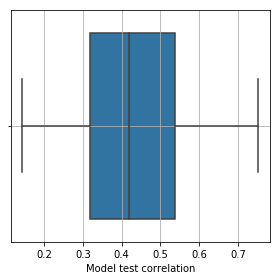

In [169]:
# Plot best results

# Plot countplot of models among best results
# Plot drugs in DNA replication pathway
plt.figure(figsize=(4, 4))

ax = sns.boxplot(x="Model test correlation", data=df_best_results_filtered)

plt.grid()

plt.tight_layout()

plt.show()

In [140]:
# Show quntalies of best results
print("First quartile:", np.quantile(df_best_results_filtered["Model test correlation"], 0.25))
print("Median:", np.quantile(df_best_results_filtered["Model test correlation"], 0.5))
print("Third quartile:", np.quantile(df_best_results_filtered["Model test correlation"], 0.75))

# Compute interquartile range
IQR = np.quantile(df_best_results_filtered["Model test correlation"], 0.75) - \
    np.quantile(df_best_results_filtered["Model test correlation"], 0.25)
print("Interquartile range:", IQR)
print("One forth of the drugs:", df_best_results_filtered.shape[0] / 4)

First quartile: 0.3196955848668826
Median: 0.42038868318694983
Third quartile: 0.5367075405401784
Interquartile range: 0.21701195567329584
One forth of the drugs: 58.0


In [163]:
df = df_best_results_filtered[
    df_best_results_filtered["Model test correlation"] > \
    np.quantile(df_best_results_filtered["Model test correlation"], 0.75)
]
df = df_best_results.iloc[:15]
df

,Drug ID,Drug Name,Model test correlation,Correlation pval,Relative test RMSE,Model test RMSE,Dummy test RMSE,Corresponding experiment,Target Pathway
0,1373,Dabrafenib,0.752645,1.075014e-40,1.514006,0.127750,0.193280,OT + S RF,ERK MAPK signaling
1,277,Linifanib,0.749668,4.346970e-19,1.483354,0.055801,0.080856,OT RF,RTK signaling
2,1372,Trametinib,0.708743,3.211507e-40,1.404737,0.202283,0.284112,GW EN,ERK MAPK signaling
3,281,Alectinib,0.700389,9.898418e-30,1.407981,0.062192,0.086656,GW EN,RTK signaling
4,52,GNF-2,0.698448,2.000000e-01,1.246686,0.043907,0.053700,OT EN,ABL signaling
5,1014,Refametinib,0.681474,1.429625e-32,1.363201,0.132921,0.181089,GW EN,ERK MAPK signaling
6,1011,Navitoclax,0.669291,1.149977e-31,1.323833,0.137786,0.182344,GW RF,Apoptosis regulation
7,29,AZ628,0.665869,1.405101e-15,1.314646,0.155821,0.204761,OT + S EN,ERK MAPK signaling
8,275,I-BET-762,0.653524,1.073992e-26,1.318135,0.115021,0.151155,PG + S EN,Chromatin other
9,1242,(5Z)-7-Oxozeaenol,0.648544,4.310664e-30,1.299131,0.139781,0.181556,GW EN,"Other, kinases"


In [164]:
df["Corresponding experiment"].value_counts()

GW EN        7
OT + S EN    2
PG + S EN    1
GW RF        1
OT RF        1
GW SEL RF    1
OT + S RF    1
OT EN        1
Name: Corresponding experiment, dtype: int64

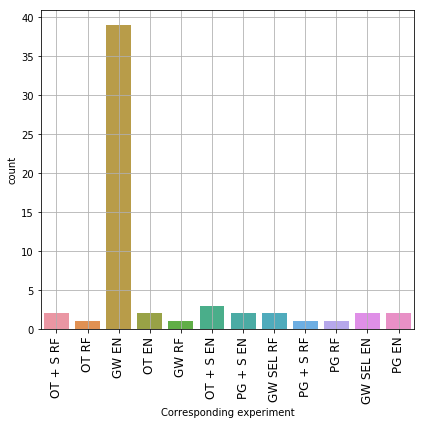

In [147]:
# Plot countplot of models among best results
# Plot drugs in DNA replication pathway
plt.figure(figsize=(6, 6))

ax = sns.countplot(x="Corresponding experiment", data=df)

plt.xticks(rotation=90, fontsize=12)
plt.grid()

plt.tight_layout()

plt.show()

#### Frequency of genome-wide methods as function of top k performances

In [19]:
print(df_best_results["Corresponding experiment"].unique())
df_best_results.head()

['OT + S RF' 'OT RF' 'GW EN' 'OT EN' 'GW RF' 'OT + S EN' 'PG + S EN'
 'GW SEL RF' 'PG + S RF' 'PG RF' 'GW SEL EN' 'PG EN']


,Drug ID,Drug Name,Model test correlation,Correlation pval,Relative test RMSE,Model test RMSE,Dummy test RMSE,Corresponding experiment,Target Pathway
0,1373,Dabrafenib,0.752645,1.075014e-40,1.514006,0.127750,0.193280,OT + S RF,ERK MAPK signaling
1,277,Linifanib,0.749668,4.346970e-19,1.483354,0.055801,0.080856,OT RF,RTK signaling
2,1372,Trametinib,0.708743,3.211507e-40,1.404737,0.202283,0.284112,GW EN,ERK MAPK signaling
3,281,Alectinib,0.700389,9.898418e-30,1.407981,0.062192,0.086656,GW EN,RTK signaling
4,52,GNF-2,0.698448,2.000000e-01,1.246686,0.043907,0.053700,OT EN,ABL signaling


In [20]:
# Create new binary column with models
dic = {"OT + S RF": "Restricted",
       "OT RF": "Restricted",
       "GW EN": "Genome-wide",
       "OT EN": "Restricted",
       "GW RF": "Genome-wide",
       "OT + S EN": "Restricted",
       "PG + S EN": "Restricted",
       "GW SEL RF": "Genome-wide",
       "PG + S RF": "Restricted",
       "PG RF": "Restricted",
       "GW SEL EN": "Genome-wide",
       "PG EN": "Restricted"
      }
data = df_best_results.copy()
data["Model binary"] = data["Corresponding experiment"].map(dic)
print(df_best_results.shape, data.shape)

(251, 9) (251, 10)


In [21]:
data.head()

,Drug ID,Drug Name,Model test correlation,Correlation pval,Relative test RMSE,Model test RMSE,Dummy test RMSE,Corresponding experiment,Target Pathway,Model binary
0,1373,Dabrafenib,0.752645,1.075014e-40,1.514006,0.127750,0.193280,OT + S RF,ERK MAPK signaling,Restricted
1,277,Linifanib,0.749668,4.346970e-19,1.483354,0.055801,0.080856,OT RF,RTK signaling,Restricted
2,1372,Trametinib,0.708743,3.211507e-40,1.404737,0.202283,0.284112,GW EN,ERK MAPK signaling,Genome-wide
3,281,Alectinib,0.700389,9.898418e-30,1.407981,0.062192,0.086656,GW EN,RTK signaling,Genome-wide
4,52,GNF-2,0.698448,2.000000e-01,1.246686,0.043907,0.053700,OT EN,ABL signaling,Restricted


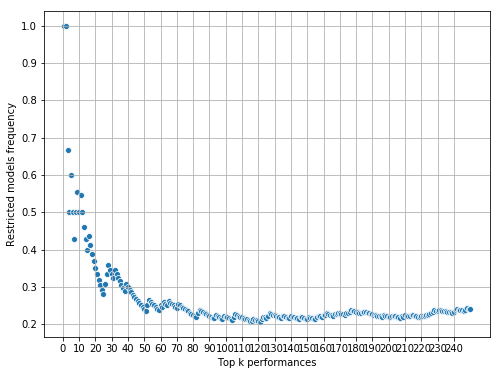

In [69]:
# Create xs and ys for plotting
xs = [x for x in range(1, data.shape[0], 1)]

ys = []
for x in xs:
    df = data.iloc[:x]
    try:
        freq = df["Model binary"].value_counts(normalize=True)["Restricted"]
    except KeyError:
        freq = 0
    ys.append(freq)

# Do the plotting
plt.figure(figsize=(8, 6))

ax = sns.scatterplot(xs, ys)

ax.set_ylabel("Restricted models frequency", fontsize=10)
ax.set_xlabel("Top k performances", fontsize=10)
ax.set_xticks([x for x in range(0, 250, 10)])
ax.set_xticklabels([x for x in range(0, 250, 10)])

# Add a horizontal line
#ax.axhline(0.5, color="black", linewidth=2)

plt.grid()

plt.show()

In [68]:
[x for x in ax.get_xticklabels()]

[Text(-50.0, 0, '−50'),
 Text(0.0, 0, '0'),
 Text(50.0, 0, '50'),
 Text(100.0, 0, '100'),
 Text(150.0, 0, '150'),
 Text(200.0, 0, '200'),
 Text(250.0, 0, '250'),
 Text(300.0, 0, '300')]

In [40]:
df["Model binary"].value_counts(normalize=True)

Restricted     0.666667
Genome-wide    0.333333
Name: Model binary, dtype: float64

## Best results from DNA replication pathway

In [13]:
# Load DataFrame with aggregated results for all drugs, with models classified to two groups
df_restricted_vs_gw = pd.read_csv("./Results and other files/df_agg_all_drugs_restricted_vs_genome_wide.csv")
print(df_restricted_vs_gw.shape, df_restricted_vs_gw["Drug ID"].nunique(), df_restricted_vs_gw["Model"].nunique())
df_restricted_vs_gw_filtered = df_restricted_vs_gw[~df_restricted_vs_gw["Drug ID"].isin(bad_drugs)]
print(df_restricted_vs_gw_filtered["Drug ID"].nunique())
df_restricted_vs_gw_filtered.sample(5)

(2412, 9) 251 2
232


,Drug ID,Drug Name,Model test RMSE,Model test correlation,Correlation pval,Dummy test RMSE,Relative test RMSE,Target Pathway,Model
2381,1495,Olaparib,0.053155,0.396299,2.989237e-08,0.057157,1.077792,Genome integrity,Restricted
1735,1026,Tanespimycin,0.153194,0.626478,2.939887e-27,0.193754,1.264547,Protein stability and degradation,Genome-wide
1850,1047,Nutlin-3a (-),0.066715,0.527298,8.600619e-14,0.078151,1.173883,p53 pathway,Restricted
1313,301,PHA-793887,0.162563,0.615181,3.100363e-27,0.205207,1.261988,Cell cycle,Genome-wide
1321,301,PHA-793887,0.169668,0.563983,1.041032e-22,0.205207,1.209264,Cell cycle,Genome-wide


In [14]:
df_dna_rep_all_models = df_agg_all_models_filtered[
    df_agg_all_models_filtered["Target Pathway"] == "DNA replication"]
print(df_dna_rep_all_models.shape, df_dna_rep_all_models["Drug ID"].nunique())

(88, 9) 11


In [1]:
# Plot drugs in DNA replication pathway
plt.figure(figsize=(10, 6))

order = df_dna_rep_all_models.sort_values("Model test correlation", ascending=False)[
    "Drug Name"].unique()

ax = sns.swarmplot(x="Drug Name", y="Model test correlation", data=df_dna_rep_all_models,
                  hue="Model",
                  order=order,
                  palette=sns.color_palette("Paired"),
                  size=7,
                  linewidth=1,
                  dodge=True,
                  alpha=1.)

ax.set_xlabel("Drug Name", fontsize=14)
ax.set_ylabel("Correlation", fontsize=14)

plt.legend(loc="upper left", bbox_to_anchor=(1,1))

plt.xticks(rotation=90, fontsize=12)
plt.grid()

plt.tight_layout()

plt.savefig("/home/krzysztof/Dokumenty/Doktorat/Dokumenty/Prezentacje Merck Skype/pres_merck_May_15_2019/Figures/dna_rep_best_drugs.pdf")

plt.show()

NameError: name 'plt' is not defined

In [16]:
df_dna_rep_all_models[
    df_dna_rep_all_models["Drug Name"] == "SN-38"
]

,Drug ID,Drug Name,Model test RMSE,Model test correlation,Correlation pval,Dummy test RMSE,Relative test RMSE,Target Pathway,Model
2368,1494,SN-38,0.159469,0.613526,2.017998e-27,0.201083,1.263385,DNA replication,GW RF
2369,1494,SN-38,0.178165,0.423292,4.056034e-10,0.196734,1.106285,DNA replication,PG + S EN
2370,1494,SN-38,0.191002,0.316634,3.646045e-06,0.201083,1.053436,DNA replication,OT EN
2371,1494,SN-38,0.183186,0.376085,3.129690e-07,0.196734,1.074835,DNA replication,PG EN
2372,1494,SN-38,0.193741,0.288438,9.873052e-05,0.201083,1.039041,DNA replication,OT RF
2373,1494,SN-38,0.187313,0.312649,3.134217e-06,0.196734,1.050431,DNA replication,PG RF
2374,1494,SN-38,0.158217,0.617248,2.368819e-26,0.201083,1.274346,DNA replication,GW EN
2375,1494,SN-38,0.187276,0.376426,1.887468e-08,0.201083,1.074820,DNA replication,OT + S EN
2376,1494,SN-38,0.178529,0.422664,4.418260e-11,0.196734,1.102586,DNA replication,PG + S RF
2377,1494,SN-38,0.159290,0.610725,5.970578e-28,0.201083,1.263320,DNA replication,GW SEL RF


In [17]:
df_drugs_of_interest.rename(columns = {"Corresponding experiment": "Model"}, inplace=True)

In [18]:
df_drugs_of_interest

,Drug ID,Drug Name,Model test correlation,Correlation pval,Relative test RMSE,Model test RMSE,Dummy test RMSE,Model,Target Pathway
0,1373,Dabrafenib,0.752645,1.075014e-40,1.514006,0.127750,0.193280,OT + S RF,ERK MAPK signaling
1,277,Linifanib,0.749668,4.346970e-19,1.483354,0.055801,0.080856,OT RF,RTK signaling
2,1372,Trametinib,0.708743,3.211507e-40,1.404737,0.202283,0.284112,GW EN,ERK MAPK signaling
3,281,Alectinib,0.700389,9.898418e-30,1.407981,0.062192,0.086656,GW EN,RTK signaling
5,1014,Refametinib,0.681474,1.429625e-32,1.363201,0.132921,0.181089,GW EN,ERK MAPK signaling


In [19]:
dna_rep_best_models= df_best_results_filtered[
    df_best_results_filtered["Drug Name"].isin(["Bleomycin (50 uM)", "Methotrexate", "SN-38"])
]
dna_rep_best_models = dna_rep_best_models.rename(columns={"Corresponding experiment": "Model"})
dna_rep_best_models

,Drug ID,Drug Name,Model test correlation,Correlation pval,Relative test RMSE,Model test RMSE,Dummy test RMSE,Model,Target Pathway
17,1378,Bleomycin (50 uM),0.633202,2.697727e-29,1.282015,0.196886,0.252266,GW EN,DNA replication
19,1008,Methotrexate,0.627378,1.526236e-27,1.273898,0.108074,0.137579,GW EN,DNA replication
22,1494,SN-38,0.617248,2.368819e-26,1.274346,0.158217,0.201083,GW EN,DNA replication


In [20]:
print(df_drugs_of_interest.shape)
df_drugs_of_interest = df_drugs_of_interest.append(dna_rep_best_models, ignore_index=True)
print(df_drugs_of_interest.shape)

(5, 9)
(8, 9)


In [21]:
df_drugs_of_interest

,Drug ID,Drug Name,Model test correlation,Correlation pval,Relative test RMSE,Model test RMSE,Dummy test RMSE,Model,Target Pathway
0,1373,Dabrafenib,0.752645,1.075014e-40,1.514006,0.127750,0.193280,OT + S RF,ERK MAPK signaling
1,277,Linifanib,0.749668,4.346970e-19,1.483354,0.055801,0.080856,OT RF,RTK signaling
2,1372,Trametinib,0.708743,3.211507e-40,1.404737,0.202283,0.284112,GW EN,ERK MAPK signaling
3,281,Alectinib,0.700389,9.898418e-30,1.407981,0.062192,0.086656,GW EN,RTK signaling
4,1014,Refametinib,0.681474,1.429625e-32,1.363201,0.132921,0.181089,GW EN,ERK MAPK signaling
5,1378,Bleomycin (50 uM),0.633202,2.697727e-29,1.282015,0.196886,0.252266,GW EN,DNA replication
6,1008,Methotrexate,0.627378,1.526236e-27,1.273898,0.108074,0.137579,GW EN,DNA replication
7,1494,SN-38,0.617248,2.368819e-26,1.274346,0.158217,0.201083,GW EN,DNA replication


## Best results from RTK signaling pathway

In [22]:
df_rtk_sign_all_models = df_agg_all_models_filtered[
    df_agg_all_models_filtered["Target Pathway"] == "RTK signaling"
]
print(df_rtk_sign_all_models.shape, df_rtk_sign_all_models["Drug ID"].nunique())

(192, 9) 18


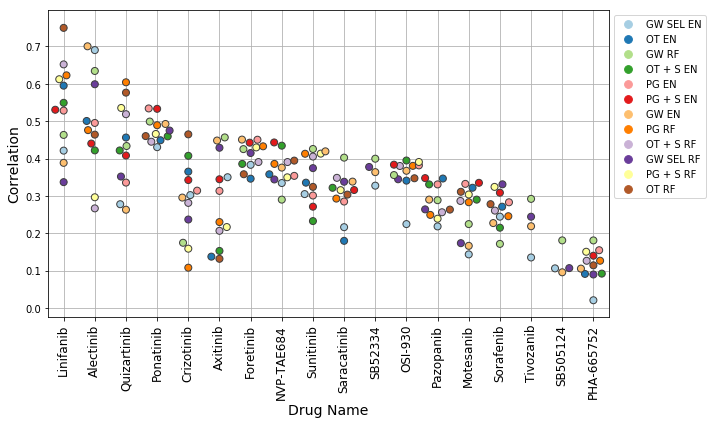

In [23]:
# Plot drugs in DNA replication pathway
plt.figure(figsize=(10, 6))

order = df_rtk_sign_all_models.sort_values("Model test correlation", ascending=False)[
    "Drug Name"].unique()

ax = sns.swarmplot(x="Drug Name", y="Model test correlation", data=df_rtk_sign_all_models,
                  hue="Model",
                  order=order,
                  palette=sns.color_palette("Paired"),
                  size=7,
                  linewidth=1,
                  dodge=False,
                  alpha=1.)

ax.set_xlabel("Drug Name", fontsize=14)
ax.set_ylabel("Correlation", fontsize=14)

plt.legend(loc="upper left", bbox_to_anchor=(1,1))

plt.xticks(rotation=90, fontsize=12)
plt.grid()

plt.tight_layout()

plt.show()

## Best results from ERK MAPK signaling pathway

In [24]:
df_erk_sign_all_models = df_agg_all_models_filtered[
    df_agg_all_models_filtered["Target Pathway"] == "ERK MAPK signaling"
]
print(df_erk_sign_all_models.shape, df_erk_sign_all_models["Drug ID"].nunique())

(120, 9) 14


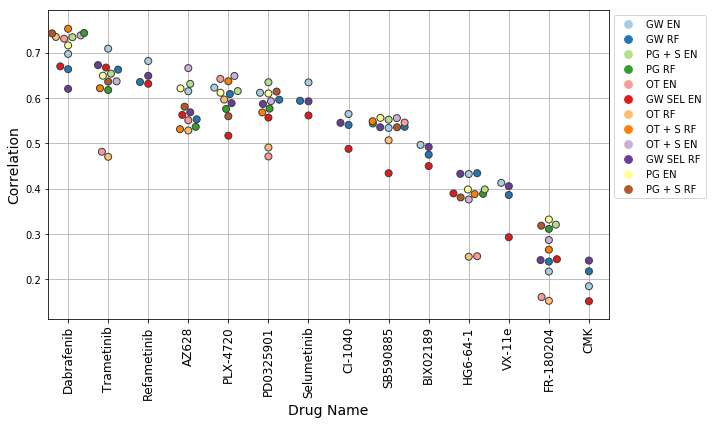

In [25]:
# Plot drugs in ERK MAPK signaling pathway
plt.figure(figsize=(10, 6))

order = df_erk_sign_all_models.sort_values("Model test correlation", ascending=False)[
    "Drug Name"].unique()

ax = sns.swarmplot(x="Drug Name", y="Model test correlation", data=df_erk_sign_all_models,
                  hue="Model",
                  order=order,
                  palette=sns.color_palette("Paired"),
                  size=7,
                  linewidth=1,
                  dodge=False,
                  alpha=1.)

ax.set_xlabel("Drug Name", fontsize=14)
ax.set_ylabel("Correlation", fontsize=14)

plt.legend(loc="upper left", bbox_to_anchor=(1,1))

plt.xticks(rotation=90, fontsize=12)
plt.grid()

plt.tight_layout()

plt.show()

In [26]:
df_drugs_of_interest

,Drug ID,Drug Name,Model test correlation,Correlation pval,Relative test RMSE,Model test RMSE,Dummy test RMSE,Model,Target Pathway
0,1373,Dabrafenib,0.752645,1.075014e-40,1.514006,0.127750,0.193280,OT + S RF,ERK MAPK signaling
1,277,Linifanib,0.749668,4.346970e-19,1.483354,0.055801,0.080856,OT RF,RTK signaling
2,1372,Trametinib,0.708743,3.211507e-40,1.404737,0.202283,0.284112,GW EN,ERK MAPK signaling
3,281,Alectinib,0.700389,9.898418e-30,1.407981,0.062192,0.086656,GW EN,RTK signaling
4,1014,Refametinib,0.681474,1.429625e-32,1.363201,0.132921,0.181089,GW EN,ERK MAPK signaling
5,1378,Bleomycin (50 uM),0.633202,2.697727e-29,1.282015,0.196886,0.252266,GW EN,DNA replication
6,1008,Methotrexate,0.627378,1.526236e-27,1.273898,0.108074,0.137579,GW EN,DNA replication
7,1494,SN-38,0.617248,2.368819e-26,1.274346,0.158217,0.201083,GW EN,DNA replication


## Best results from EGFR singaling pathways

In [27]:
df_egfr_sign_all_models = df_agg_all_models_filtered[
    df_agg_all_models_filtered["Target Pathway"] == "EGFR signaling"
]
print(df_egfr_sign_all_models.shape, df_egfr_sign_all_models["Drug ID"].nunique())

(84, 9) 7


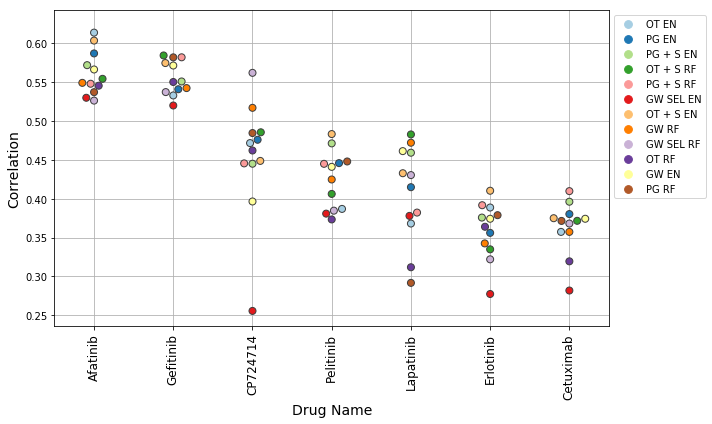

In [28]:
# Plot drugs in ERK MAPK signaling pathway
plt.figure(figsize=(10, 6))

order = df_egfr_sign_all_models.sort_values("Model test correlation", ascending=False)[
    "Drug Name"].unique()

ax = sns.swarmplot(x="Drug Name", y="Model test correlation", data=df_egfr_sign_all_models,
                  hue="Model",
                  order=order,
                  palette=sns.color_palette("Paired"),
                  size=7,
                  linewidth=1,
                  dodge=False,
                  alpha=1.)

ax.set_xlabel("Drug Name", fontsize=14)
ax.set_ylabel("Correlation", fontsize=14)

plt.legend(loc="upper left", bbox_to_anchor=(1,1))

plt.xticks(rotation=90, fontsize=12)
plt.grid()

plt.tight_layout()

plt.show()

In [29]:
df_drugs_of_interest

,Drug ID,Drug Name,Model test correlation,Correlation pval,Relative test RMSE,Model test RMSE,Dummy test RMSE,Model,Target Pathway
0,1373,Dabrafenib,0.752645,1.075014e-40,1.514006,0.127750,0.193280,OT + S RF,ERK MAPK signaling
1,277,Linifanib,0.749668,4.346970e-19,1.483354,0.055801,0.080856,OT RF,RTK signaling
2,1372,Trametinib,0.708743,3.211507e-40,1.404737,0.202283,0.284112,GW EN,ERK MAPK signaling
3,281,Alectinib,0.700389,9.898418e-30,1.407981,0.062192,0.086656,GW EN,RTK signaling
4,1014,Refametinib,0.681474,1.429625e-32,1.363201,0.132921,0.181089,GW EN,ERK MAPK signaling
5,1378,Bleomycin (50 uM),0.633202,2.697727e-29,1.282015,0.196886,0.252266,GW EN,DNA replication
6,1008,Methotrexate,0.627378,1.526236e-27,1.273898,0.108074,0.137579,GW EN,DNA replication
7,1494,SN-38,0.617248,2.368819e-26,1.274346,0.158217,0.201083,GW EN,DNA replication


In [30]:
df_drugs_of_interest.drop(5, inplace=True)

In [31]:
df_drugs_of_interest

,Drug ID,Drug Name,Model test correlation,Correlation pval,Relative test RMSE,Model test RMSE,Dummy test RMSE,Model,Target Pathway
0,1373,Dabrafenib,0.752645,1.075014e-40,1.514006,0.127750,0.193280,OT + S RF,ERK MAPK signaling
1,277,Linifanib,0.749668,4.346970e-19,1.483354,0.055801,0.080856,OT RF,RTK signaling
2,1372,Trametinib,0.708743,3.211507e-40,1.404737,0.202283,0.284112,GW EN,ERK MAPK signaling
3,281,Alectinib,0.700389,9.898418e-30,1.407981,0.062192,0.086656,GW EN,RTK signaling
4,1014,Refametinib,0.681474,1.429625e-32,1.363201,0.132921,0.181089,GW EN,ERK MAPK signaling
6,1008,Methotrexate,0.627378,1.526236e-27,1.273898,0.108074,0.137579,GW EN,DNA replication
7,1494,SN-38,0.617248,2.368819e-26,1.274346,0.158217,0.201083,GW EN,DNA replication


In [32]:
df = df_best_results[
    df_best_results["Drug Name"] == "Afatinib"
]
df.rename(columns={"Corresponding experiment": "Model"}, inplace=True)
df

/home/krzysztof/anaconda3/envs/modeling_drug_efficacy/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,Drug ID,Drug Name,Model test correlation,Correlation pval,Relative test RMSE,Model test RMSE,Dummy test RMSE,Model,Target Pathway
27,1377,Afatinib,0.61387,1.163713e-26,1.254071,0.125199,0.157065,OT EN,EGFR signaling


In [33]:
print(df_drugs_of_interest.shape)
df_drugs_of_interest = df_drugs_of_interest.append(df, ignore_index=True)
print(df_drugs_of_interest.shape)

(7, 9)
(8, 9)


In [34]:
df_drugs_of_interest

,Drug ID,Drug Name,Model test correlation,Correlation pval,Relative test RMSE,Model test RMSE,Dummy test RMSE,Model,Target Pathway
0,1373,Dabrafenib,0.752645,1.075014e-40,1.514006,0.127750,0.193280,OT + S RF,ERK MAPK signaling
1,277,Linifanib,0.749668,4.346970e-19,1.483354,0.055801,0.080856,OT RF,RTK signaling
2,1372,Trametinib,0.708743,3.211507e-40,1.404737,0.202283,0.284112,GW EN,ERK MAPK signaling
3,281,Alectinib,0.700389,9.898418e-30,1.407981,0.062192,0.086656,GW EN,RTK signaling
4,1014,Refametinib,0.681474,1.429625e-32,1.363201,0.132921,0.181089,GW EN,ERK MAPK signaling
5,1008,Methotrexate,0.627378,1.526236e-27,1.273898,0.108074,0.137579,GW EN,DNA replication
6,1494,SN-38,0.617248,2.368819e-26,1.274346,0.158217,0.201083,GW EN,DNA replication
7,1377,Afatinib,0.613870,1.163713e-26,1.254071,0.125199,0.157065,OT EN,EGFR signaling


## Best results from ABL signaling pathway

In [36]:
df_abl_sign_all_models = df_agg_all_models_filtered[
    df_agg_all_models_filtered["Target Pathway"] == "ABL signaling"
]
print(df_abl_sign_all_models.shape, df_abl_sign_all_models["Drug ID"].nunique())

(24, 9) 2


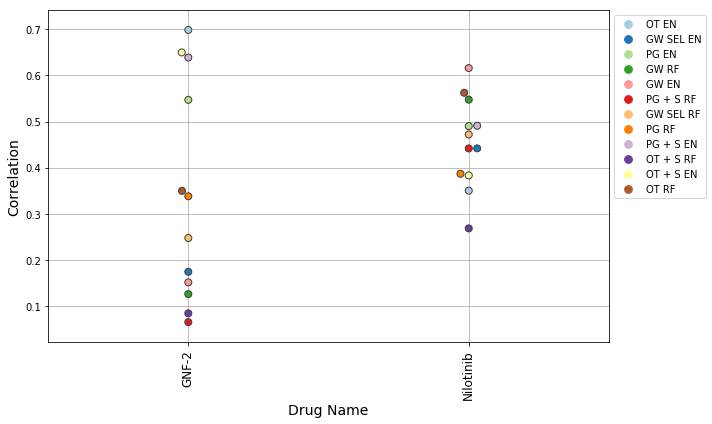

In [38]:
# Plot drugs in ABL signaling pathway
plt.figure(figsize=(10, 6))

order = df_abl_sign_all_models.sort_values("Model test correlation", ascending=False)[
    "Drug Name"].unique()

ax = sns.swarmplot(x="Drug Name", y="Model test correlation", data=df_abl_sign_all_models,
                  hue="Model",
                  order=order,
                  palette=sns.color_palette("Paired"),
                  size=7,
                  linewidth=1,
                  dodge=False,
                  alpha=1.)

ax.set_xlabel("Drug Name", fontsize=14)
ax.set_ylabel("Correlation", fontsize=14)

plt.legend(loc="upper left", bbox_to_anchor=(1,1))

plt.xticks(rotation=90, fontsize=12)
plt.grid()

plt.tight_layout()

plt.show()

In [40]:
df_drugs_of_interest

,Drug ID,Drug Name,Model test correlation,Correlation pval,Relative test RMSE,Model test RMSE,Dummy test RMSE,Model,Target Pathway
0,1373,Dabrafenib,0.752645,1.075014e-40,1.514006,0.127750,0.193280,OT + S RF,ERK MAPK signaling
1,277,Linifanib,0.749668,4.346970e-19,1.483354,0.055801,0.080856,OT RF,RTK signaling
2,1372,Trametinib,0.708743,3.211507e-40,1.404737,0.202283,0.284112,GW EN,ERK MAPK signaling
3,281,Alectinib,0.700389,9.898418e-30,1.407981,0.062192,0.086656,GW EN,RTK signaling
4,1014,Refametinib,0.681474,1.429625e-32,1.363201,0.132921,0.181089,GW EN,ERK MAPK signaling
5,1008,Methotrexate,0.627378,1.526236e-27,1.273898,0.108074,0.137579,GW EN,DNA replication
6,1494,SN-38,0.617248,2.368819e-26,1.274346,0.158217,0.201083,GW EN,DNA replication
7,1377,Afatinib,0.613870,1.163713e-26,1.254071,0.125199,0.157065,OT EN,EGFR signaling


In [42]:
df = df_best_results_filtered[
    df_best_results_filtered["Drug Name"] == "GNF-2"
]
df.rename(columns={"Corresponding experiment": "Model"}, inplace=True)
df

/home/krzysztof/anaconda3/envs/modeling_drug_efficacy/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,Drug ID,Drug Name,Model test correlation,Correlation pval,Relative test RMSE,Model test RMSE,Dummy test RMSE,Model,Target Pathway
4,52,GNF-2,0.698448,0.2,1.246686,0.043907,0.0537,OT EN,ABL signaling


In [43]:
print(df_drugs_of_interest.shape)
df_drugs_of_interest = df_drugs_of_interest.append(df, ignore_index=False)
print(df_drugs_of_interest.shape)

(8, 9)
(9, 9)


In [44]:
df_drugs_of_interest

,Drug ID,Drug Name,Model test correlation,Correlation pval,Relative test RMSE,Model test RMSE,Dummy test RMSE,Model,Target Pathway
0,1373,Dabrafenib,0.752645,1.075014e-40,1.514006,0.127750,0.193280,OT + S RF,ERK MAPK signaling
1,277,Linifanib,0.749668,4.346970e-19,1.483354,0.055801,0.080856,OT RF,RTK signaling
2,1372,Trametinib,0.708743,3.211507e-40,1.404737,0.202283,0.284112,GW EN,ERK MAPK signaling
3,281,Alectinib,0.700389,9.898418e-30,1.407981,0.062192,0.086656,GW EN,RTK signaling
4,1014,Refametinib,0.681474,1.429625e-32,1.363201,0.132921,0.181089,GW EN,ERK MAPK signaling
5,1008,Methotrexate,0.627378,1.526236e-27,1.273898,0.108074,0.137579,GW EN,DNA replication
6,1494,SN-38,0.617248,2.368819e-26,1.274346,0.158217,0.201083,GW EN,DNA replication
7,1377,Afatinib,0.613870,1.163713e-26,1.254071,0.125199,0.157065,OT EN,EGFR signaling
4,52,GNF-2,0.698448,2.000000e-01,1.246686,0.043907,0.053700,OT EN,ABL signaling


In [45]:
df_drugs_of_interest.to_csv("./Results and other files/drugs_of_interest.csv", index=False)

## Take a look at drugs of interest

In [46]:
df_drugs_of_interest = pd.read_csv("./Results and other files/drugs_of_interest.csv")
print(df_drugs_of_interest.shape)
df_drugs_of_interest

(9, 9)


,Drug ID,Drug Name,Model test correlation,Correlation pval,Relative test RMSE,Model test RMSE,Dummy test RMSE,Model,Target Pathway
0,1373,Dabrafenib,0.752645,1.075014e-40,1.514006,0.127750,0.193280,OT + S RF,ERK MAPK signaling
1,277,Linifanib,0.749668,4.346970e-19,1.483354,0.055801,0.080856,OT RF,RTK signaling
2,1372,Trametinib,0.708743,3.211507e-40,1.404737,0.202283,0.284112,GW EN,ERK MAPK signaling
3,281,Alectinib,0.700389,9.898418e-30,1.407981,0.062192,0.086656,GW EN,RTK signaling
4,1014,Refametinib,0.681474,1.429625e-32,1.363201,0.132921,0.181089,GW EN,ERK MAPK signaling
5,1008,Methotrexate,0.627378,1.526236e-27,1.273898,0.108074,0.137579,GW EN,DNA replication
6,1494,SN-38,0.617248,2.368819e-26,1.274346,0.158217,0.201083,GW EN,DNA replication
7,1377,Afatinib,0.613870,1.163713e-26,1.254071,0.125199,0.157065,OT EN,EGFR signaling
8,52,GNF-2,0.698448,2.000000e-01,1.246686,0.043907,0.053700,OT EN,ABL signaling


In [49]:
# Get results from all models for drugs of interest (DOI)
df_doi_all_models = df_agg_all_models_filtered[
    df_agg_all_models_filtered["Drug ID"].isin(df_drugs_of_interest["Drug ID"])
]
print(df_doi_all_models["Drug Name"].nunique(), df_doi_all_models.shape)

9 (96, 9)


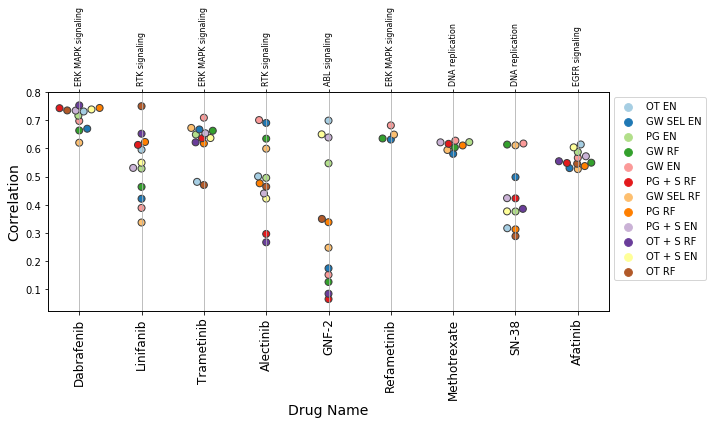

In [99]:
# Plot drugs of interest all models performance
plt.figure(figsize=(10, 6))

order = df_doi_all_models.sort_values("Model test correlation", ascending=False)[
    "Drug Name"].unique()

ax = sns.swarmplot(x="Drug Name", y="Model test correlation", data=df_doi_all_models,
                  hue="Model",
                  order=order,
                  palette=sns.color_palette("Paired"),
                  size=7,
                  linewidth=1,
                  dodge=False,
                  alpha=1.)

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())

ax2.set_xticks(ax.get_xticks())
ax2.set_xticklabels(df_drugs_of_interest.sort_values("Model test correlation", ascending=False)[
    "Target Pathway"
])

ax.set_xlabel("Drug Name", fontsize=14)
ax.set_ylabel("Correlation", fontsize=14)
ax.tick_params(axis="x", labelrotation=90, labelsize=12)
ax2.tick_params(axis="x", labelrotation=90, labelsize=8)

ax.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.grid()

plt.tight_layout()

plt.show()

In [2]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from scipy.stats import pearsonr

In [22]:
a = [1, 2, 3]
b = [1.2, 2.2, 2.9]

In [31]:
((0.2 ** 2 + 0.2 ** 2 + 0.1 ** 2) / 3) ** 0.5

0.17320508075688776

In [10]:
mean_squared_error(a, b)

0.68

In [11]:
mse = mean_squared_error(a, b)
rmse = (mse) **0.5
print(mse, rmse)

0.68 0.8246211251235321


In [43]:
r2 = r2_score(a, b)
print(r2)

0.955


In [23]:
ua = np.mean(a)
ub = np.mean(b)
print(ua, ub)

2.0 2.1


In [24]:
SStot = np.sum([(x - ua) ** 2 for x in a])
print(SStot)
SSres = np.sum([(y - f) ** 2 for y, f in zip(a, b)])
print(SSres)

2.0
0.09000000000000007


In [25]:
1 - SSres / SStot

0.955

In [28]:
pearsonr(a, b)[0] ** 2

0.9897260273972603

In [41]:
mse = mean_squared_error(a, b)
rmse = (mean_squared_error(a, b)) ** 0.5
dummy_rmse = np.std(a)
print(rmse, dummy_rmse)

0.17320508075688779 0.816496580927726


In [36]:
dummy_mse = np.sum([(x - np.mean(a)) ** 2 for x in a]) / 3
print(dummy_mse)

0.6666666666666666


In [38]:
rel_rmse = dummy_rmse / rmse
print(rel_rmse)

4.714045207910315


In [46]:
(dummy_mse / mse) ** 0.5

4.714045207910315